In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata/')

In [3]:
run_dict = {'p03':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p04':{'r000':{},'r001':{},'r002':{},'r003':{}},
            'p06':{'r000':{},'r001':{},'r002':{},'r003':{},'r004':{},'r005':{}},
            'p07':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{},'r007':{}}}
            #'p08':{          'r001':{},'r002':{},'r003':{},'r004':{},'r005':{},'r006':{}}}

In [4]:
data_path = '/Users/romoluque_c/LEGEND/Energy_scale_group/Partitioning/data_example/'

In [5]:
dt    = datetime(2023, 4, 22, 5, 54, 22, tzinfo=timezone.utc)
chmap = lmeta.hardware.configuration.channelmaps.on(dt)
channel_dict = {}
for channel_name, channel_data in chmap.items():
    try:
        channel_dict[channel_data['daq']['rawid']] = (lmeta.channelmap(dt)[channel_name].type,
                                                      channel_name,
                                                      lmeta.channelmap(dt)[channel_name].production['mass_in_g'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['string'],
                                                      lmeta.channelmap(dt)[channel_name].location  ['position'])
    except:
        continue

In [6]:
string = 1
for key, val in channel_dict.items():
    if val[3]==1:
        print(channel_dict[key])
        
channels_string1 = [f'ch{key}' for key, val in channel_dict.items() if val[3]==1]

('icpc', 'V02160A', 1750.0, 1, 1)
('icpc', 'V02160B', 1719.0, 1, 2)
('icpc', 'V05261B', 2393.0, 1, 3)
('icpc', 'V05266A', 2073.0, 1, 4)
('icpc', 'V05266B', 1988.0, 1, 5)
('icpc', 'V05268B', 1791.0, 1, 6)
('icpc', 'V05612A', 2201.0, 1, 7)
('icpc', 'V07647A', 1893, 1, 8)
('icpc', 'V07647B', 1779, 1, 9)


In [7]:
def cal_energy(e_uncal, cal_pars):
    if len(cal_pars.keys())==2:
        #print('lin')
        return cal_pars['a'] * e_uncal + cal_pars['b'], 'lin'
    elif len(cal_pars.keys())==3:
        #print('quad')
        return cal_pars['a'] * e_uncal **2 + cal_pars['b'] * e_uncal + cal_pars['c'], 'quad'
    
def uncal_quad(e_cal, cal_pars):
    return (-cal_pars['b']+np.sqrt(cal_pars['b']**2-2*cal_pars['a']*(cal_pars['c']-e_cal)))/(2*cal_pars['a'])

In [8]:
all_params_ch = {}
for sel_channel in channels_string1:
    
    pars_per_ch = {'mus_peaks':        {}, 'mus_err_peaks':   {},
                   'fwhms_peaks':      {}, 'fwhms_err_peaks': {},
                   'ecals_peaks':      {},
                   'Qbb_fwhms_in_keV': [], 'Qbb_fwhms_err_in_keV': [],
                   'eres_lin_pars0':   [], 'eres_lin_pars0_err':   [],
                   'eres_lin_pars1':   [], 'eres_lin_pars1_err':   [],
                   'gains':            [], 'Qbb_fwhms_in_ADC':     []}
    
    for i, period in enumerate(run_dict.keys()):
        for j, run in enumerate(run_dict[period].keys()):
            all_files = os.listdir(data_path)
            filename  = data_path + [f for f in all_files if f.startswith(f'l200-{period}-{run}')][0]
            with open (filename, 'r') as filehandler:
                results   = json.load(filehandler)
                res_chn   = results[sel_channel]['results']['ecal']
    
                ## Parameters for calibration
                cal_parameters = results[sel_channel]['pars']['operations']['cuspEmax_ctc_cal']['parameters']
                
                ## Parameters for resolution curve
                eres_lin_pars = res_chn['cuspEmax_ctc_cal']['eres_linear']

                pars_per_ch['Qbb_fwhms_in_keV']    .append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_in_keV']})
                pars_per_ch['Qbb_fwhms_err_in_keV'].append({f'{period}-{run}': eres_lin_pars['Qbb_fwhm_err_in_keV']})
                pars_per_ch['eres_lin_pars0']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['a']})
                pars_per_ch['eres_lin_pars0_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['a']})
                pars_per_ch['eres_lin_pars1']      .append({f'{period}-{run}': eres_lin_pars['parameters']   ['b']})
                pars_per_ch['eres_lin_pars1_err']  .append({f'{period}-{run}': eres_lin_pars['uncertainties']['b']})
                pars_per_ch['gains']               .append({f'{period}-{run}': cal_parameters['b']})
                pars_per_ch['Qbb_fwhms_in_ADC']    .append({f'{period}-{run}': uncal_quad(eres_lin_pars['Qbb_fwhm_in_keV'], cal_parameters)})
                
                fitted_peaks   = res_chn['cuspEmax_ctc_cal']['fitted_peaks']
                peak_fits_pars = res_chn['cuspEmax_ctc_cal']['pk_fits']
                
                for peak in fitted_peaks:
                    if i==0 and j==0:
                        pars_per_ch['mus_peaks']      [peak] = {}
                        pars_per_ch['mus_err_peaks']  [peak] = {}
                        pars_per_ch['fwhms_peaks']    [peak] = {}
                        pars_per_ch['fwhms_err_peaks'][peak] = {}
                        pars_per_ch['ecals_peaks']    [peak] = {}
                        
                    pars_per_ch['mus_peaks']      [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['parameters_in_ADC']   ['mu']
                    pars_per_ch['mus_err_peaks']  [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['uncertainties_in_ADC']['mu']
                    pars_per_ch['fwhms_peaks']    [peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [0]   
                    pars_per_ch['fwhms_err_peaks'][peak][f'{period}-{run}'] = peak_fits_pars[f'{peak}']['fwhm_in_keV']         [1]   
                    pars_per_ch['ecals_peaks']    [peak][f'{period}-{run}'] = cal_energy(peak_fits_pars[f'{peak}']['parameters_in_ADC']['mu'], cal_parameters)[0]

    all_params_ch[sel_channel] = pars_per_ch

In [9]:
all_params_ch.keys()

dict_keys(['ch1104000', 'ch1104001', 'ch1104002', 'ch1104003', 'ch1104004', 'ch1104005', 'ch1105600', 'ch1105602', 'ch1105603'])

In [10]:
for k1, v1 in all_params_ch.items():
    print(k1)
    for k2,v2 in all_params_ch[k1].items():
        print('         ', k2)
        try:
            for k3,v3 in all_params_ch[k1][k2].items():
                print('                ', k3)
                for k4,v4 in all_params_ch[k1][k2][k3].items():
                    print('                    ', k4)
        except:
            continue

ch1104000
          mus_peaks
                 583.191
                     p03-r000
                     p03-r001
                     p03-r002
                     p03-r003
                     p03-r004
                     p03-r005
                     p04-r000
                     p04-r001
                     p04-r002
                     p04-r003
                     p06-r000
                     p06-r001
                     p06-r002
                     p06-r003
                     p06-r004
                     p06-r005
                     p07-r001
                     p07-r002
                     p07-r003
                     p07-r004
                     p07-r005
                     p07-r006
                     p07-r007
                 727.33
                     p03-r000
                     p03-r001
                     p03-r002
                     p03-r003
                     p03-r004
                     p03-r005
                     p04-r000
                     

In [11]:
labels = [f'{key}-{run}' for key in run_dict.keys() for run in run_dict[key].keys()]

### Position of the different peaks:

In [12]:
all_fitted_peaks = np.array([583.191, 727.33, 860.564, 1592.53, 1620.5, 2103.53, 2614.5])

In [13]:
string_colors = ['#BFC2C7', '#07A9FF', '#FF9E21', '#1A2A5B', '#53BF0F', '#BB19BF', '#149A9A', '#FFB0A8', 'dimgrey'] #'#EDDAB7']

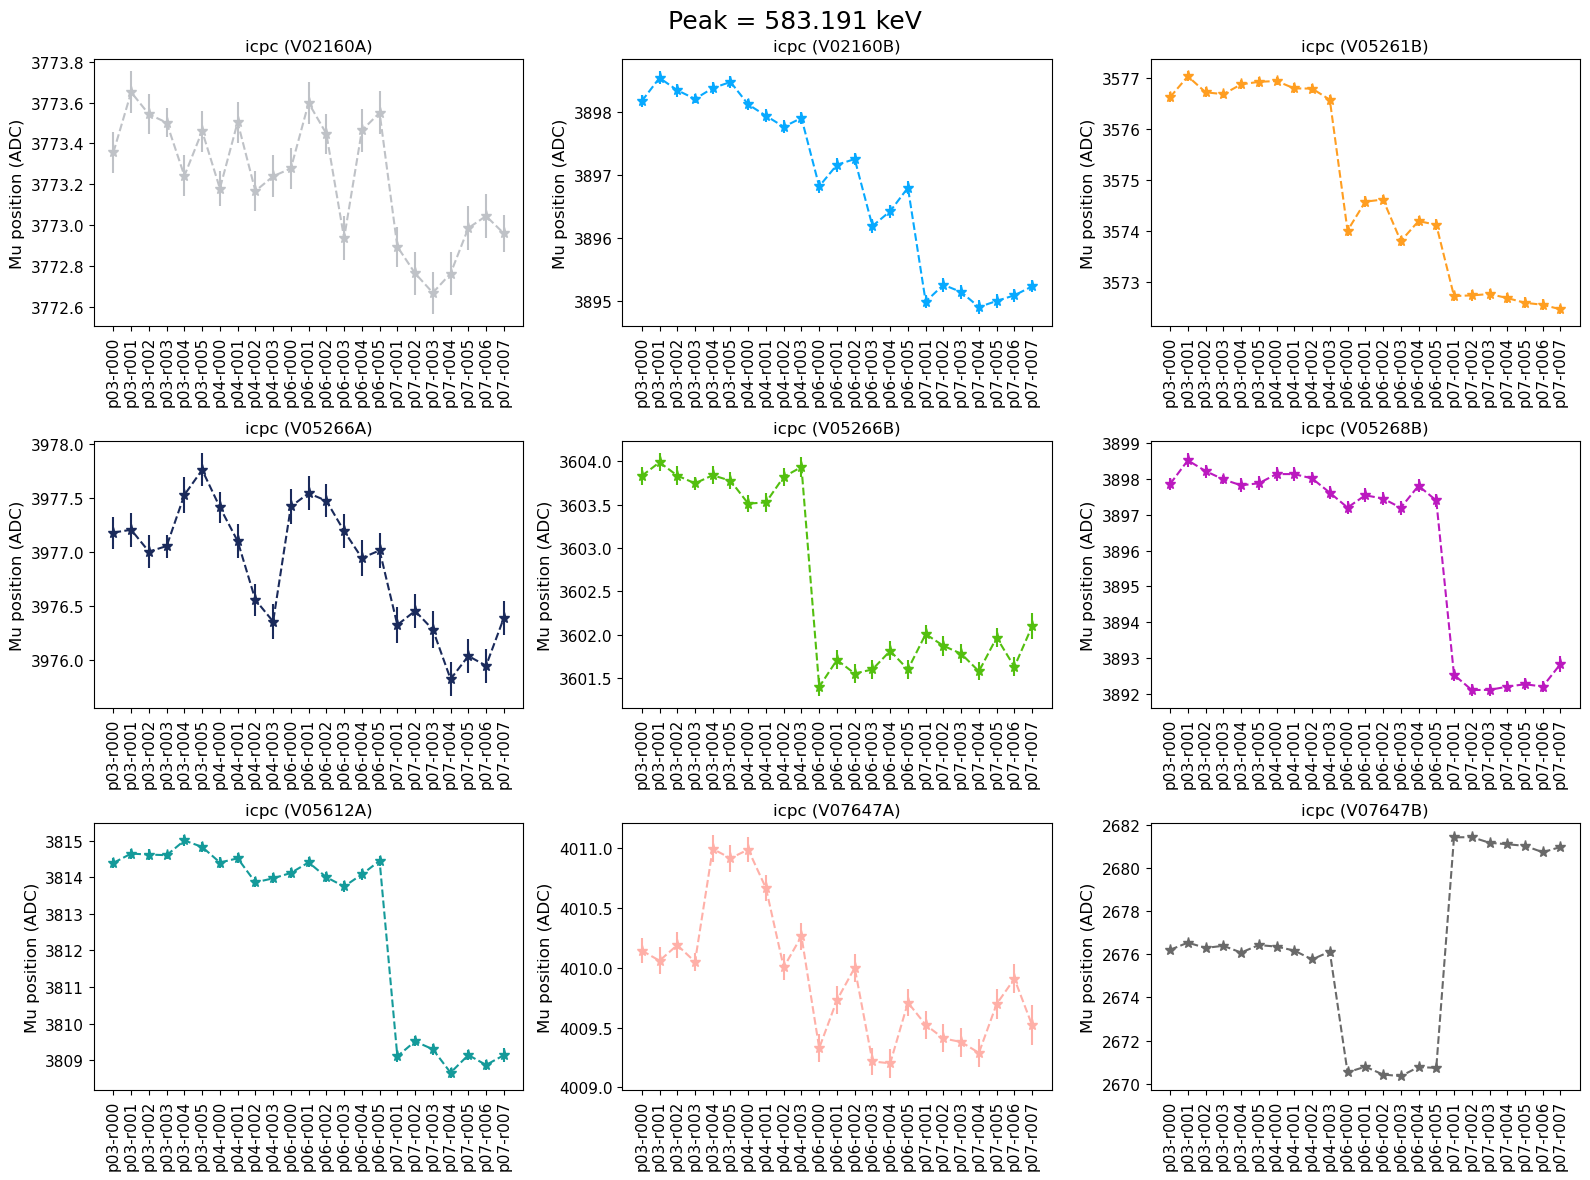


-------------------------------------------------------------------------------------------------



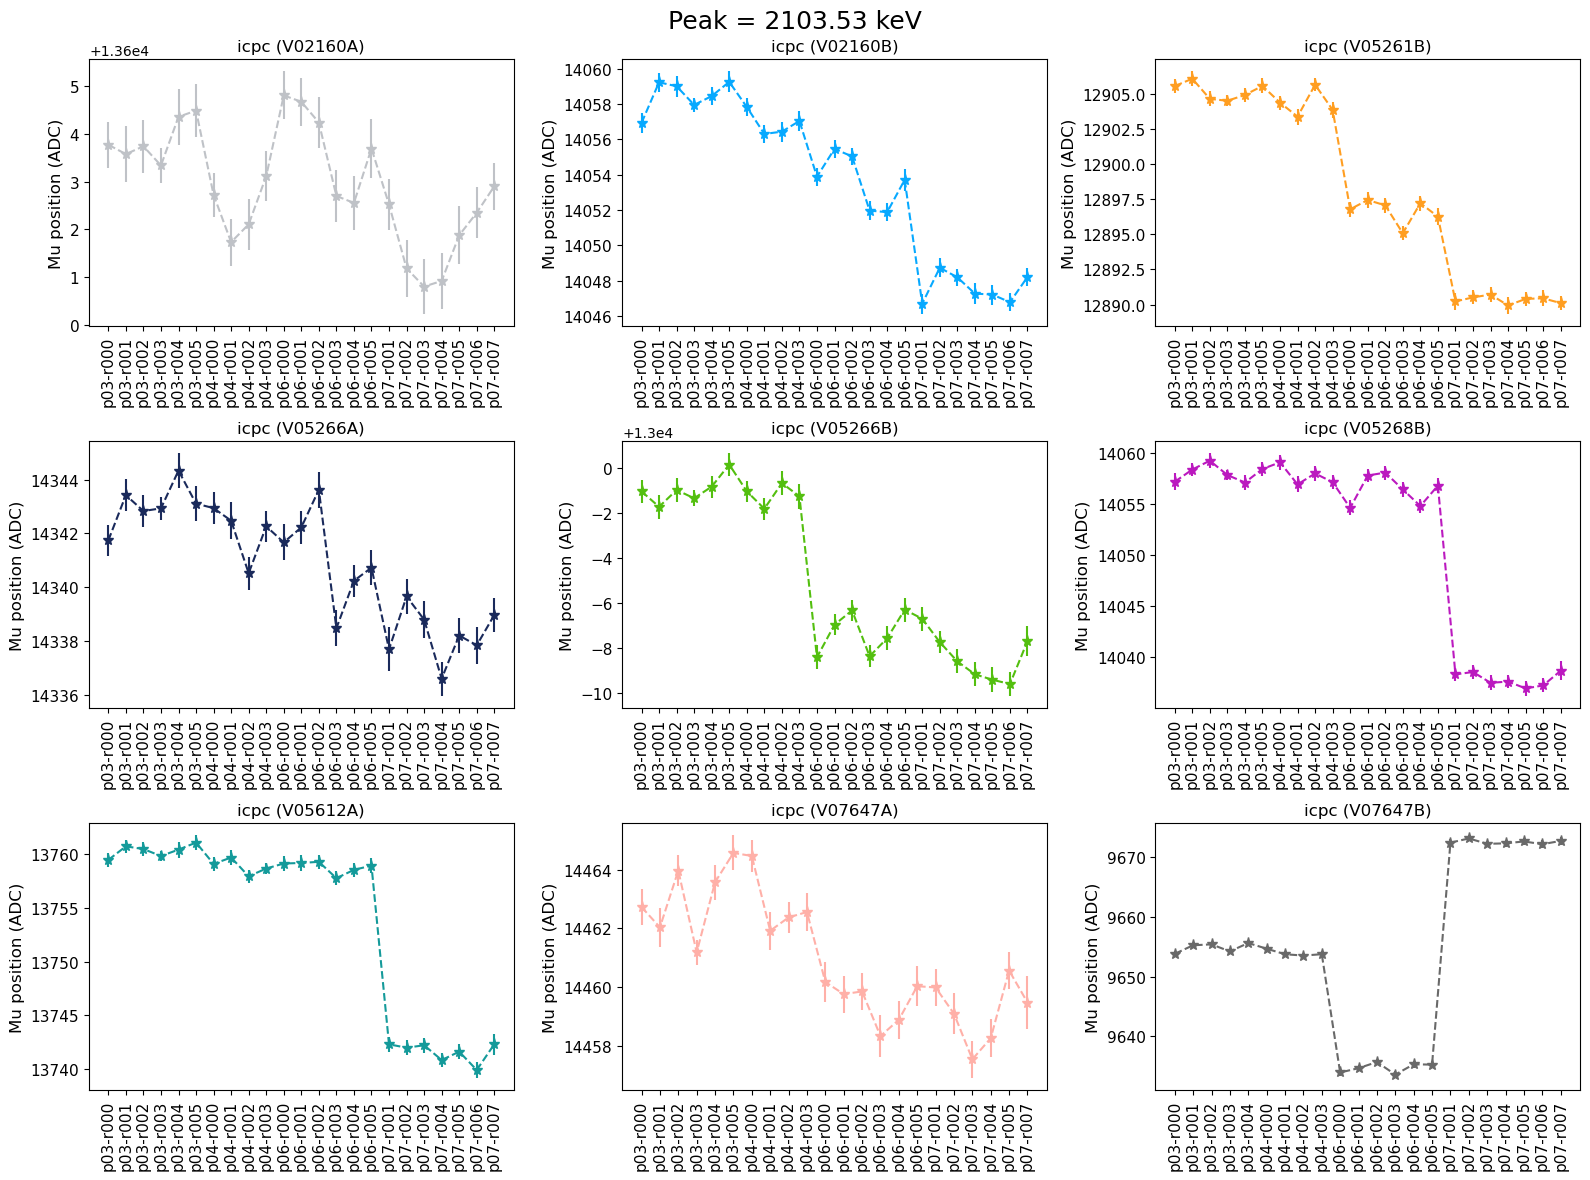


-------------------------------------------------------------------------------------------------



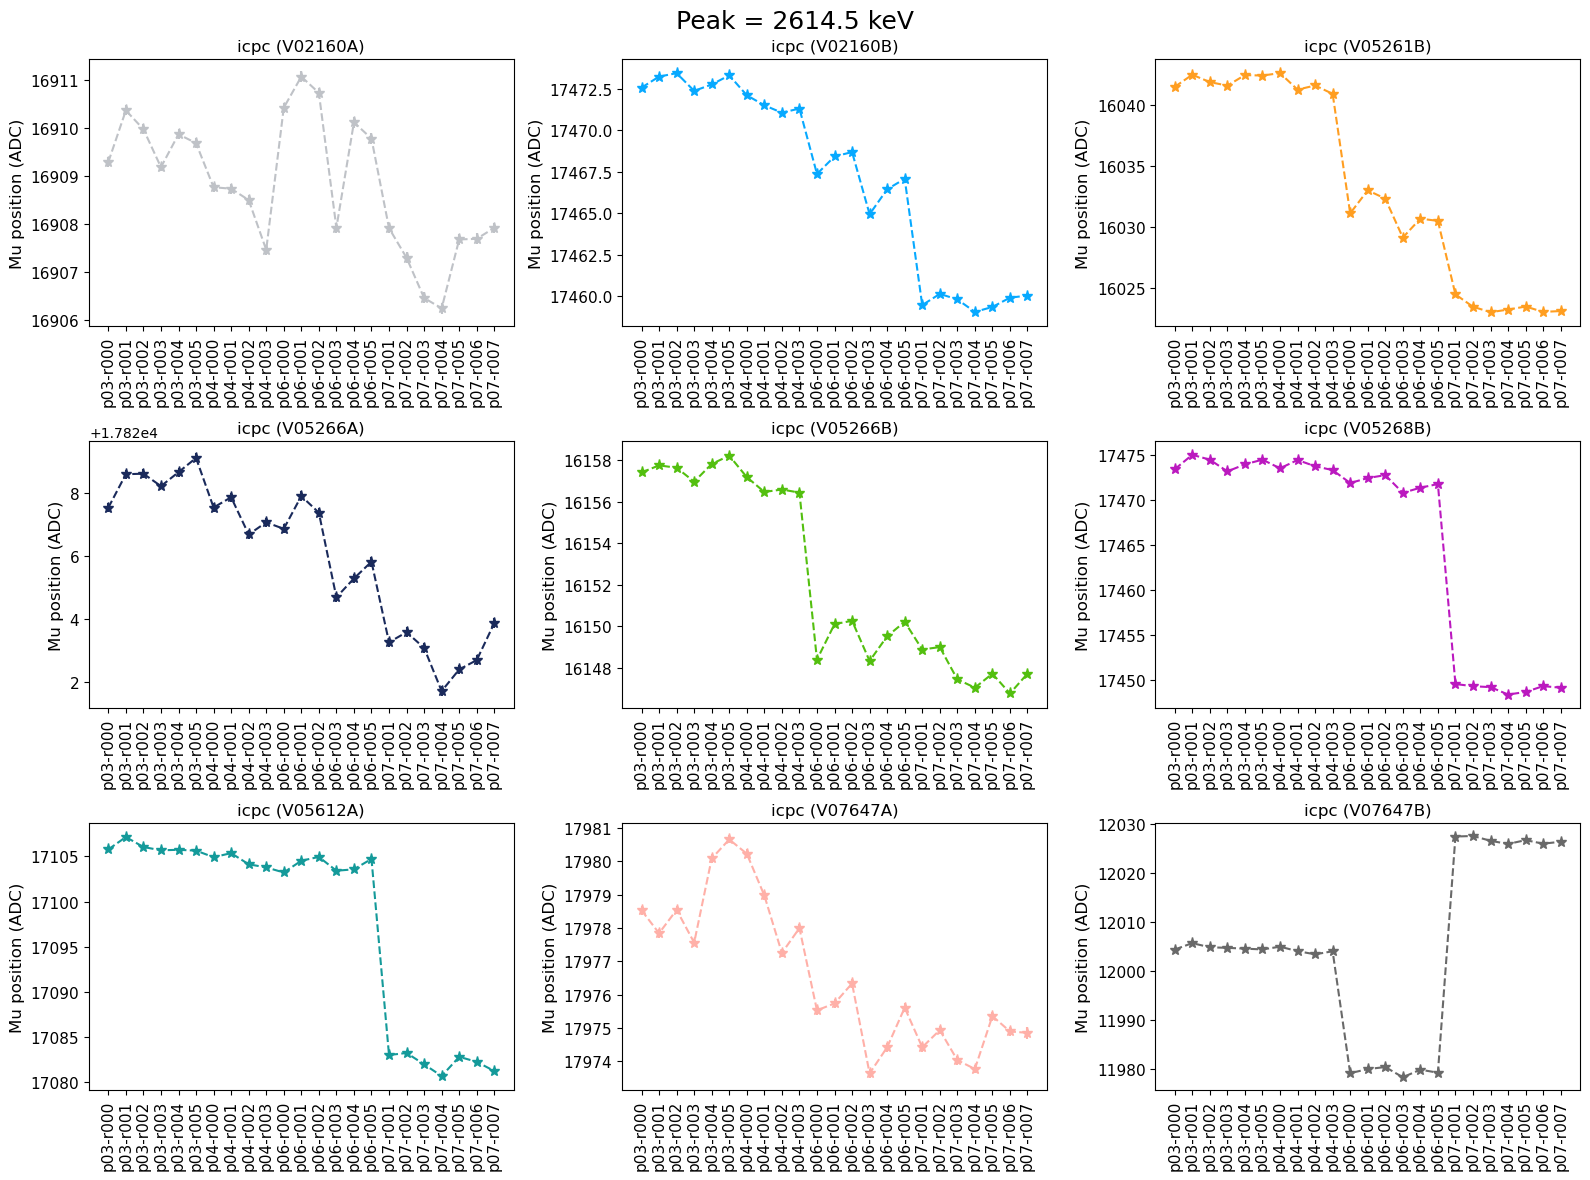


-------------------------------------------------------------------------------------------------



In [14]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 3, figsize=(16, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
        det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
        ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['mus_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                    marker='*', linestyle='--', markersize=8, label=det_type, color=col)
        ax.tick_params(axis='x', labelsize=11, rotation=90)
        ax.tick_params(axis='y', labelsize=11)
        ax.set_title(det_type, fontsize=12)
        ax.set_ylabel('Mu position (ADC)', fontsize=12)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

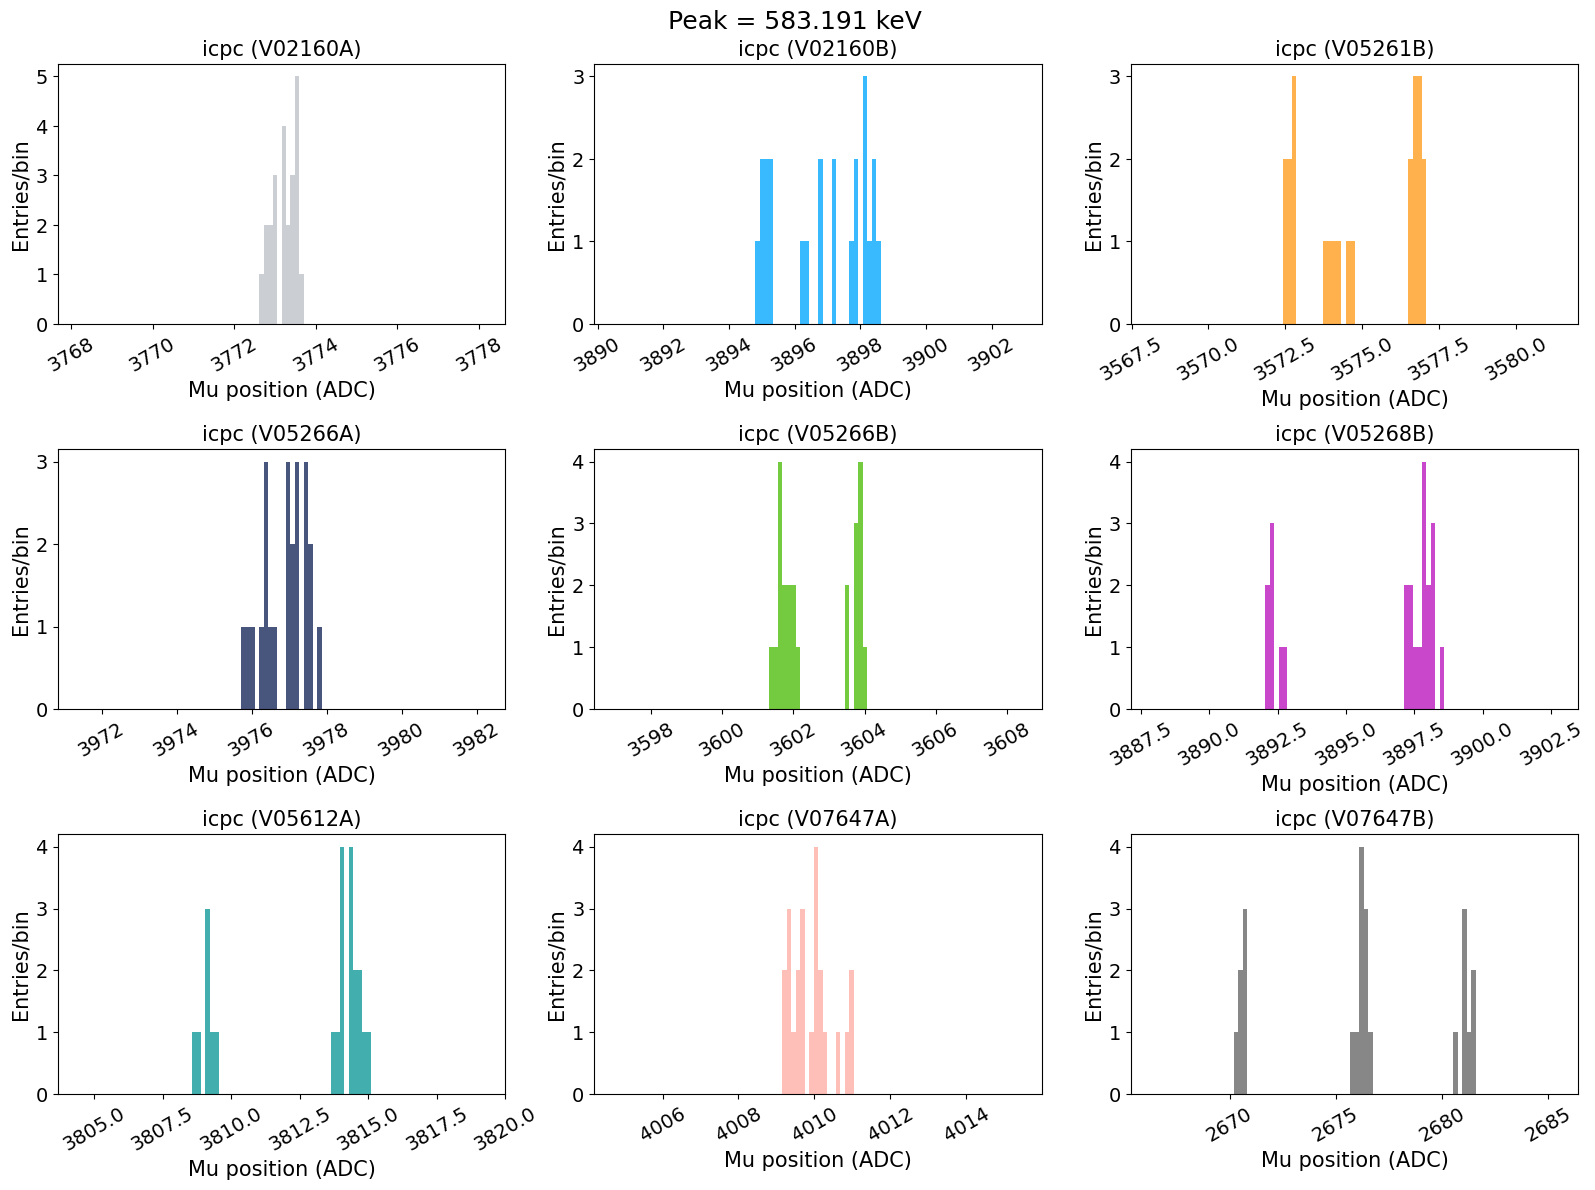


-------------------------------------------------------------------------------------------------



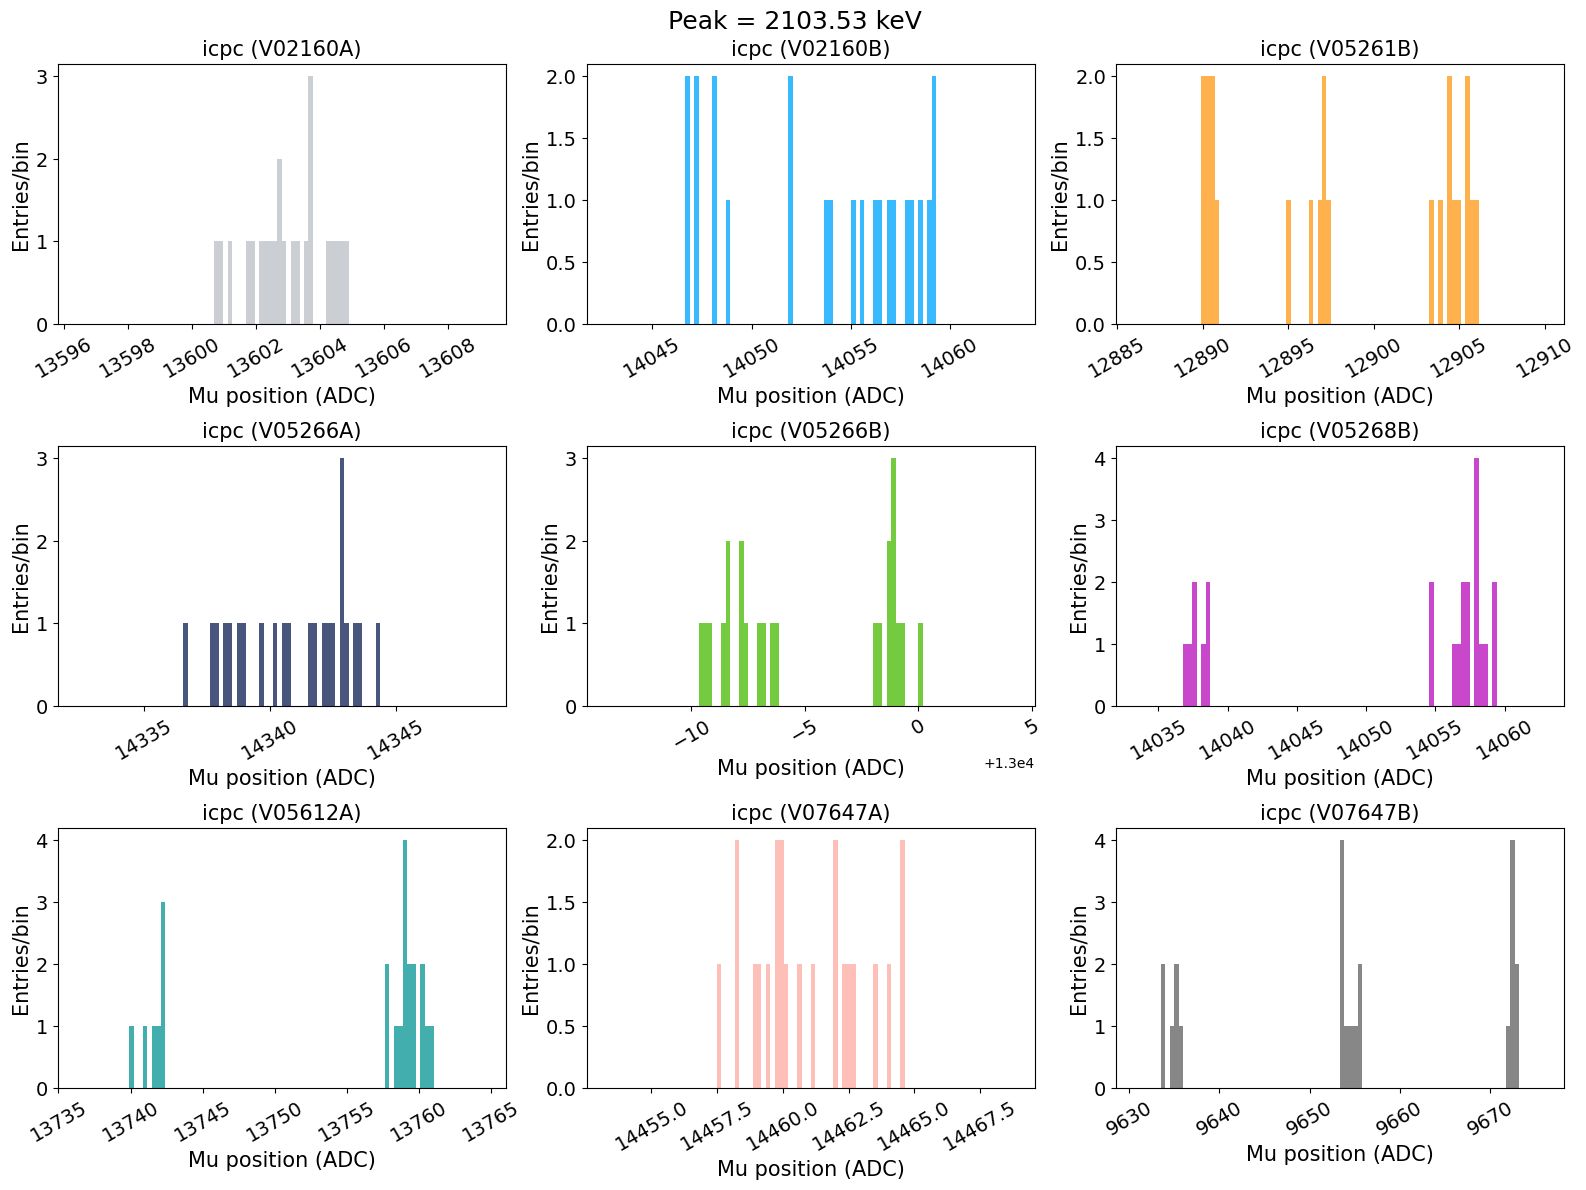


-------------------------------------------------------------------------------------------------



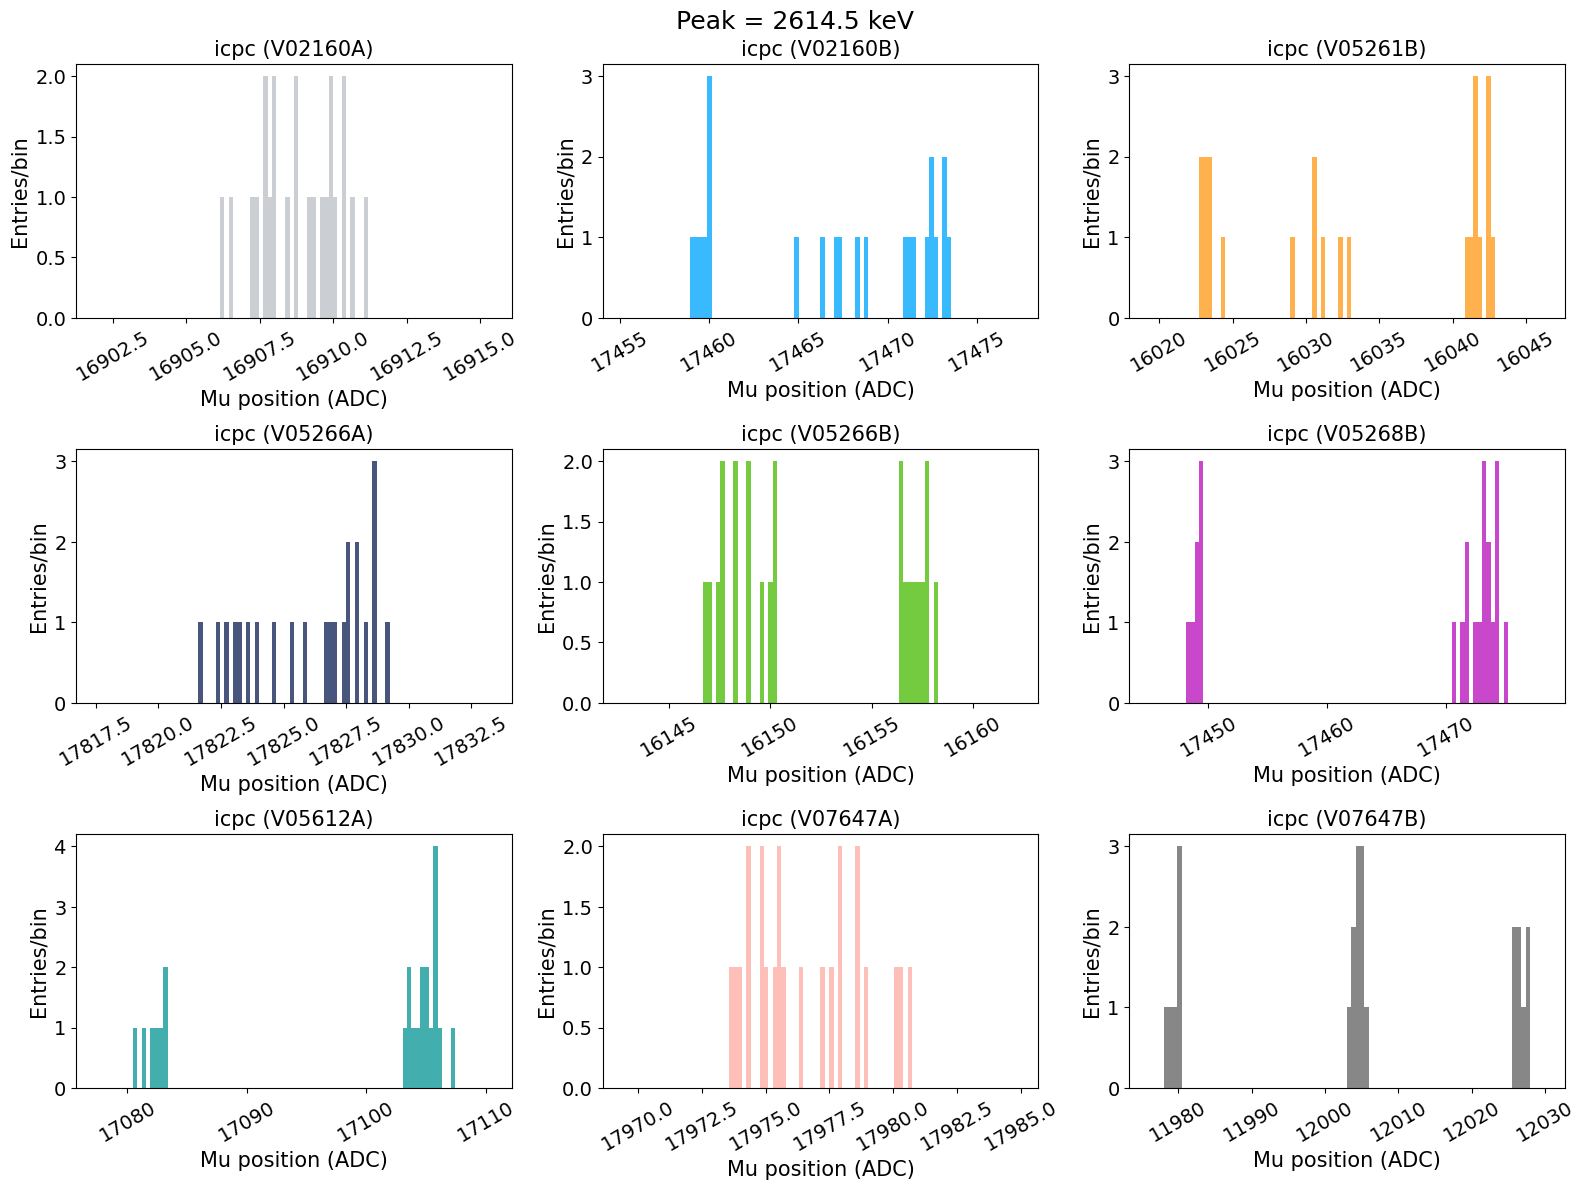


-------------------------------------------------------------------------------------------------



In [15]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 3, figsize=(16, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
        det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
        ax.hist(list(all_params_ch[channel]['mus_peaks'][peak].values()), bins=100, label=det_type, color=col, alpha=0.8,
               range=(min(list(all_params_ch[channel]['mus_peaks'][peak].values()))-5,
                      max(list(all_params_ch[channel]['mus_peaks'][peak].values()))+5))
        ax.tick_params(axis='x', labelsize=14, rotation=30)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_xlim(min(list(all_params_ch[channel]['mus_peaks'][peak].values()))-5,
                    max(list(all_params_ch[channel]['mus_peaks'][peak].values()))+5)
        ax.set_title(det_type, fontsize=15)
        ax.set_xlabel('Mu position (ADC)', fontsize=15)
        ax.set_ylabel('Entries/bin', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

### FWHM for all peaks:

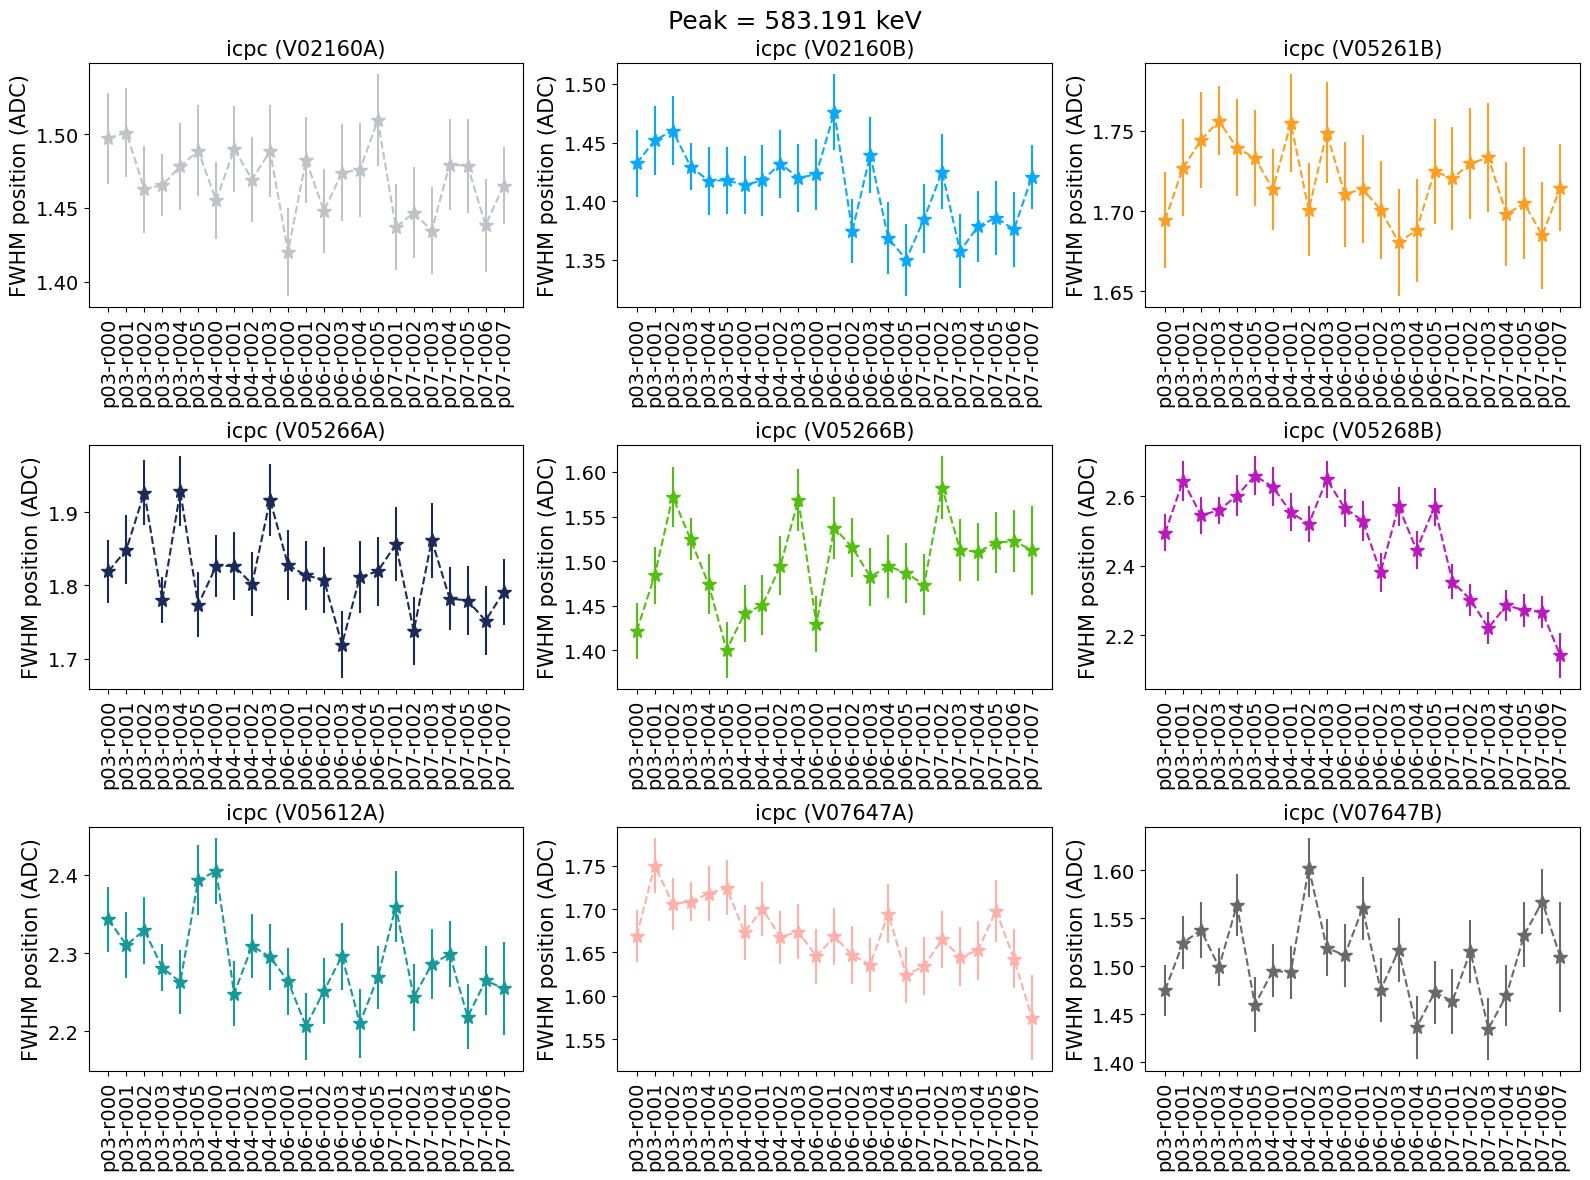


-------------------------------------------------------------------------------------------------



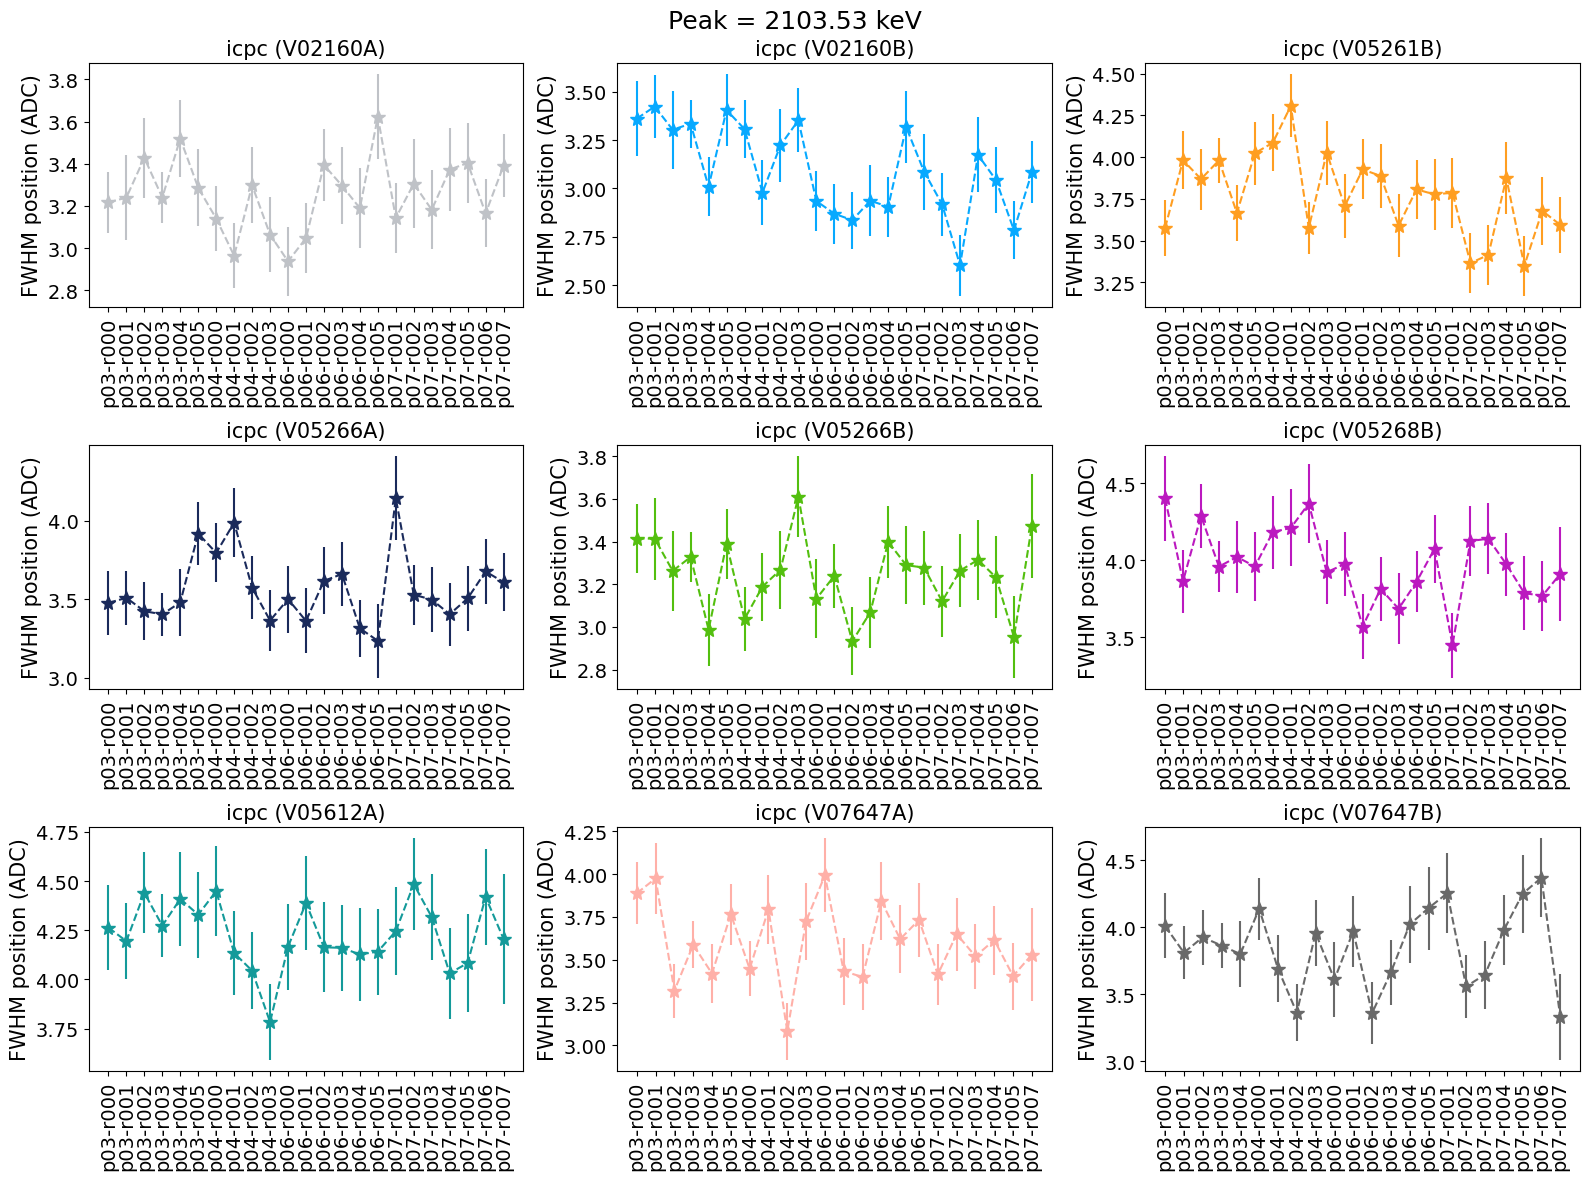


-------------------------------------------------------------------------------------------------



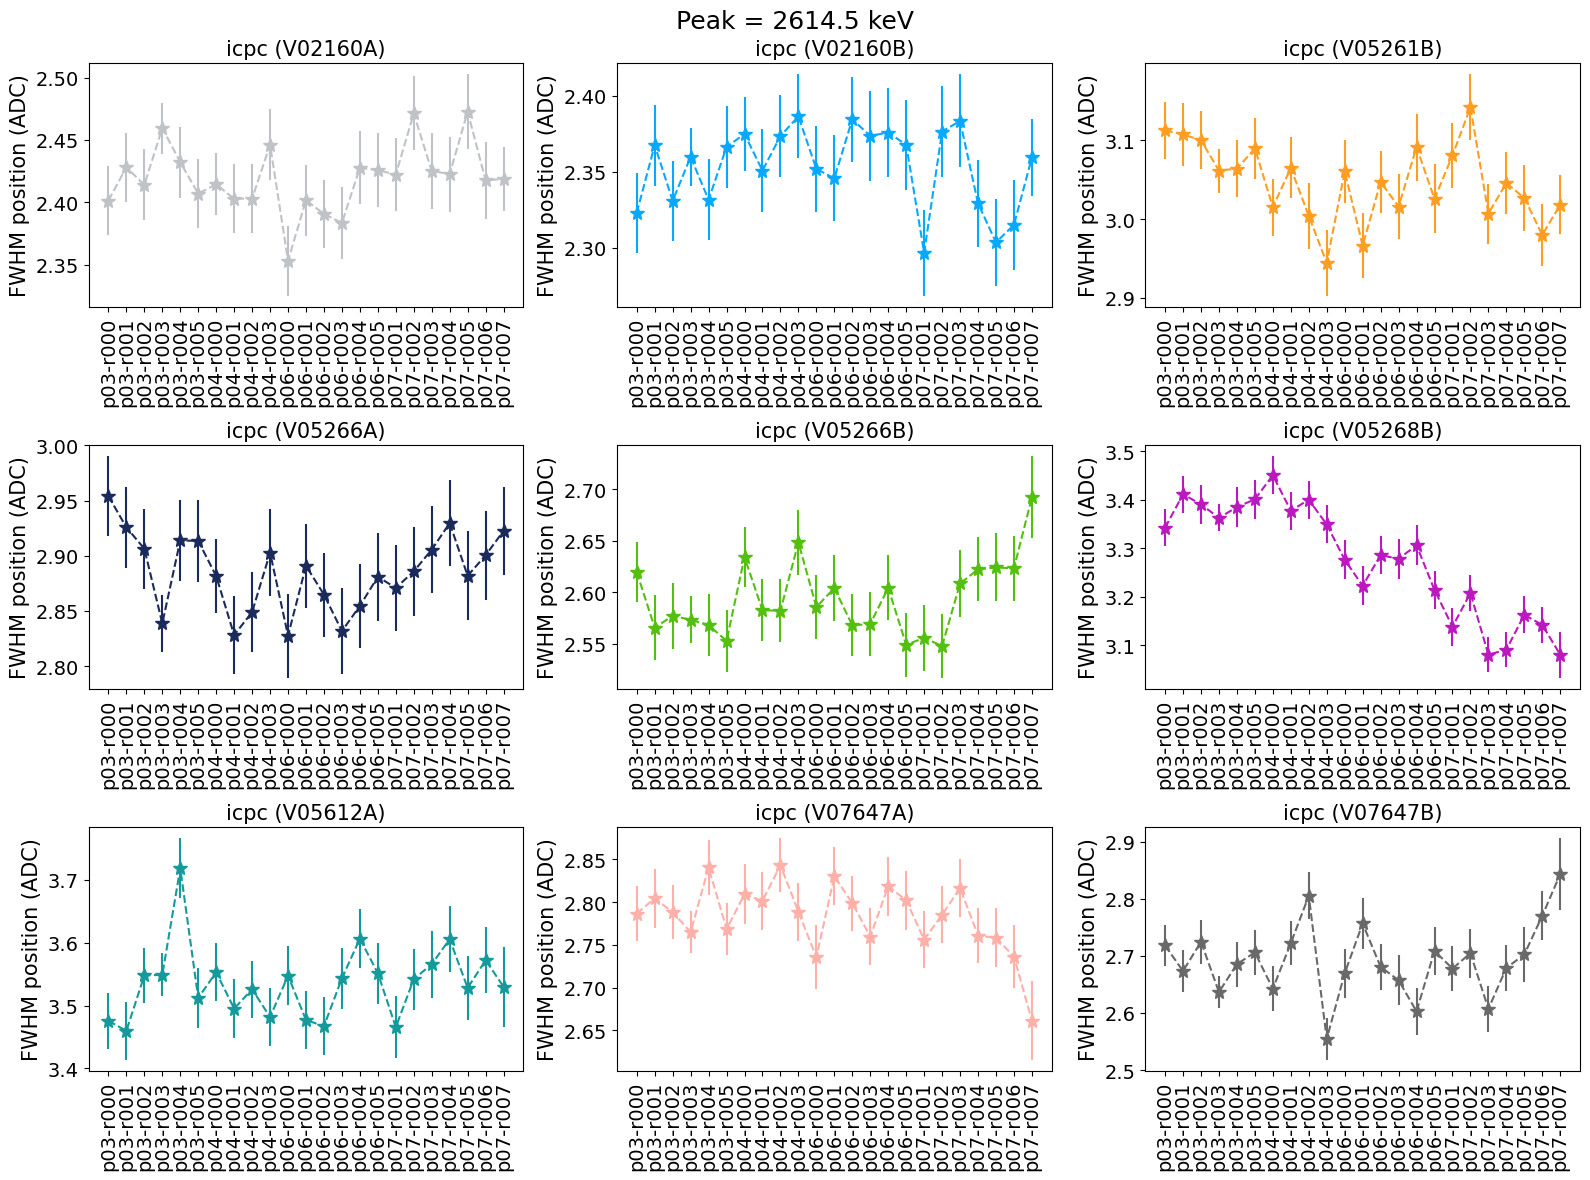


-------------------------------------------------------------------------------------------------



In [16]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 3, figsize=(16, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
        det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
        ax.errorbar(list(all_params_ch[channel]['fwhms_peaks'][peak].keys()), 
                    list(all_params_ch[channel]['fwhms_peaks'][peak].values()),
                    yerr=list(all_params_ch[channel]['fwhms_err_peaks'][peak].values()),
                    marker='*', linestyle='--', markersize=10, label=det_type, color=col)
        ax.tick_params(axis='x', labelsize=14, rotation=90)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(det_type, fontsize=15)
        ax.set_ylabel('FWHM position (ADC)', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

### Residuals

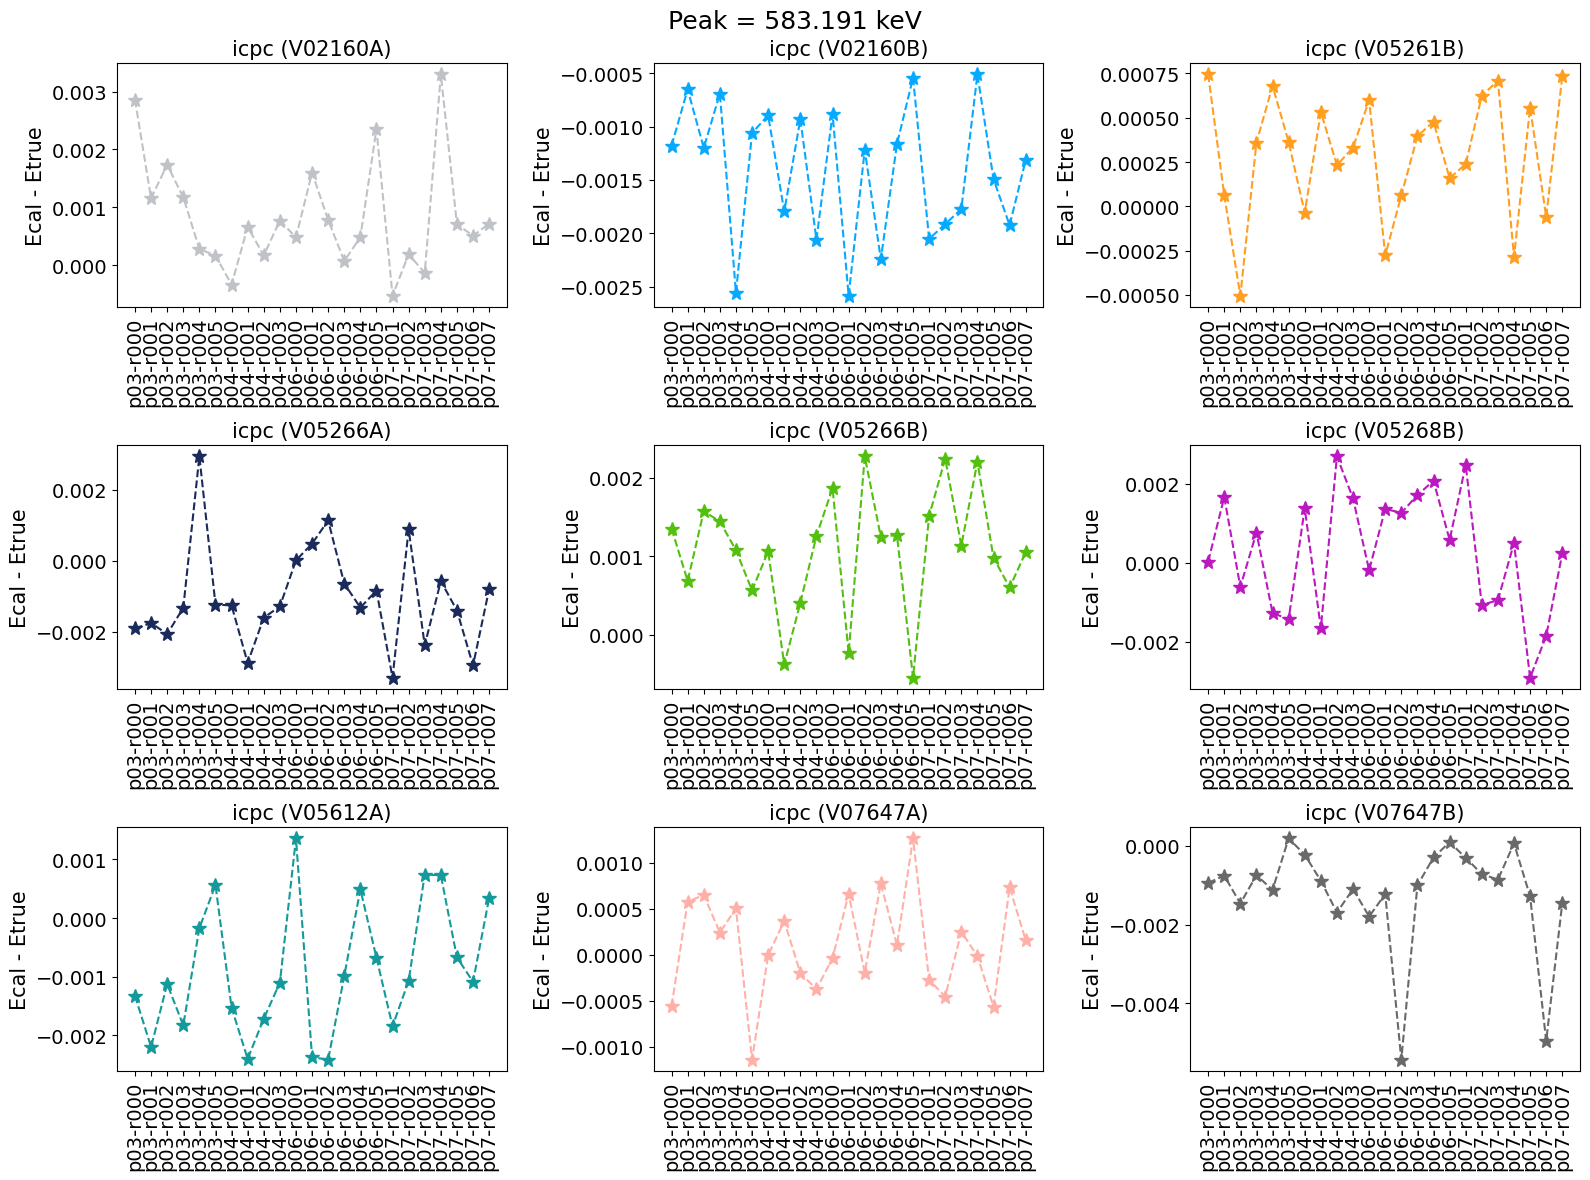


-------------------------------------------------------------------------------------------------



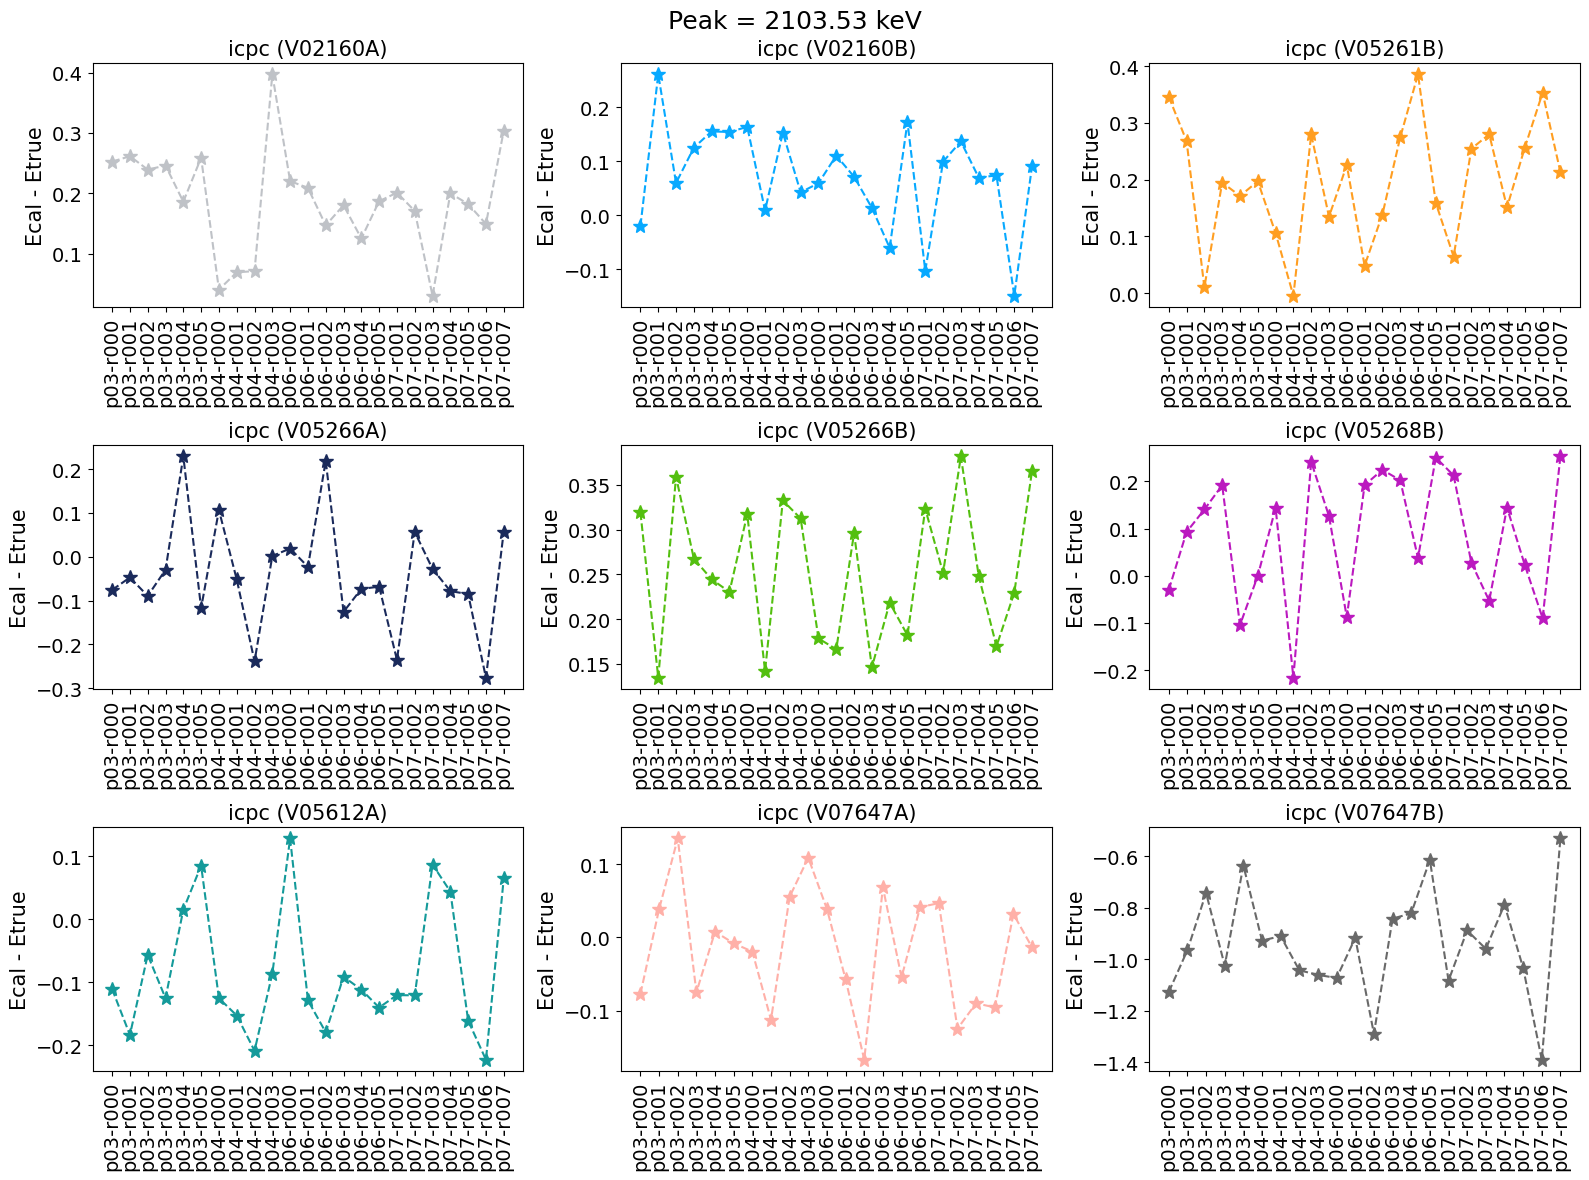


-------------------------------------------------------------------------------------------------



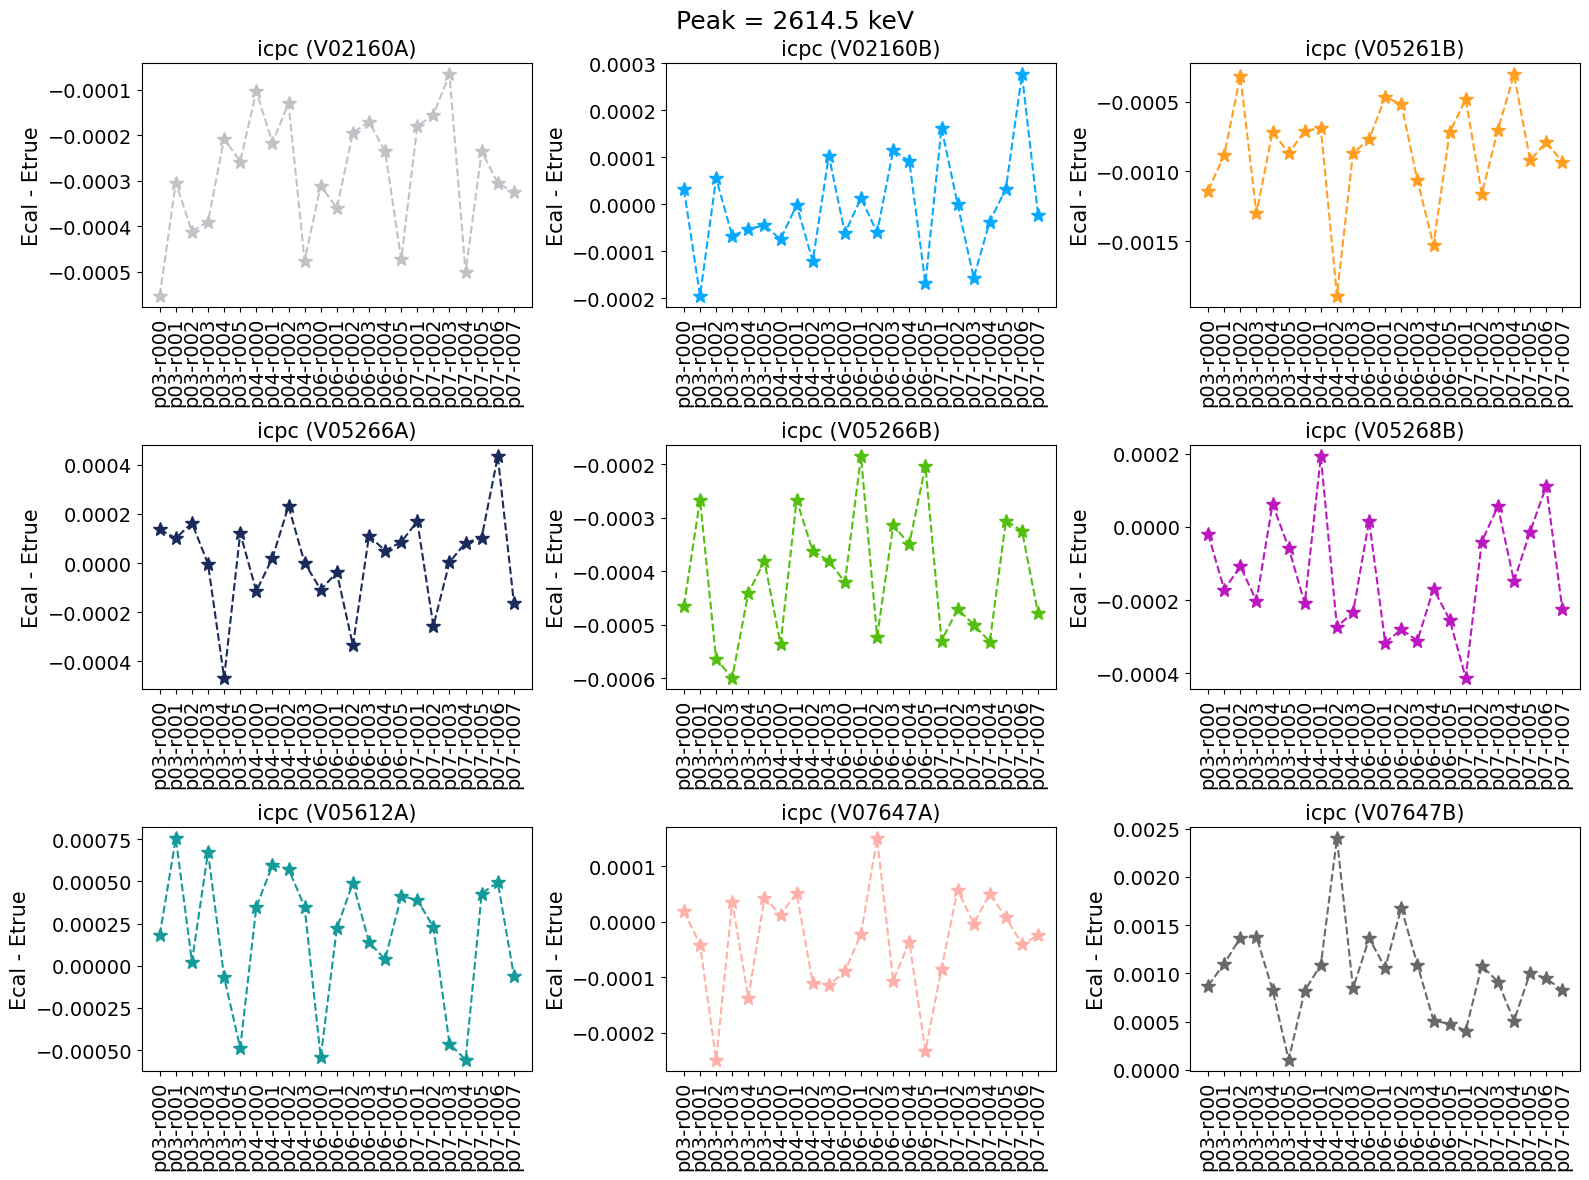


-------------------------------------------------------------------------------------------------



In [17]:
for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
    fig, axs = plt.subplots(3, 3, figsize=(16, 12))
    for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
        det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
        ax.errorbar(list(all_params_ch[channel]['ecals_peaks'][peak].keys()), 
                    np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak,
                    marker='*', linestyle='--', markersize=10, label=det_type, color=col)
        ax.tick_params(axis='x', labelsize=14, rotation=90)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_title(det_type, fontsize=15)
        ax.set_ylabel('Ecal - Etrue', fontsize=15)
    fig.suptitle(f'Peak = {peak} keV', fontsize=18)
    plt.tight_layout()
    plt.show()
    print()
    print('-------------------------------------------------------------------------------------------------')
    print()

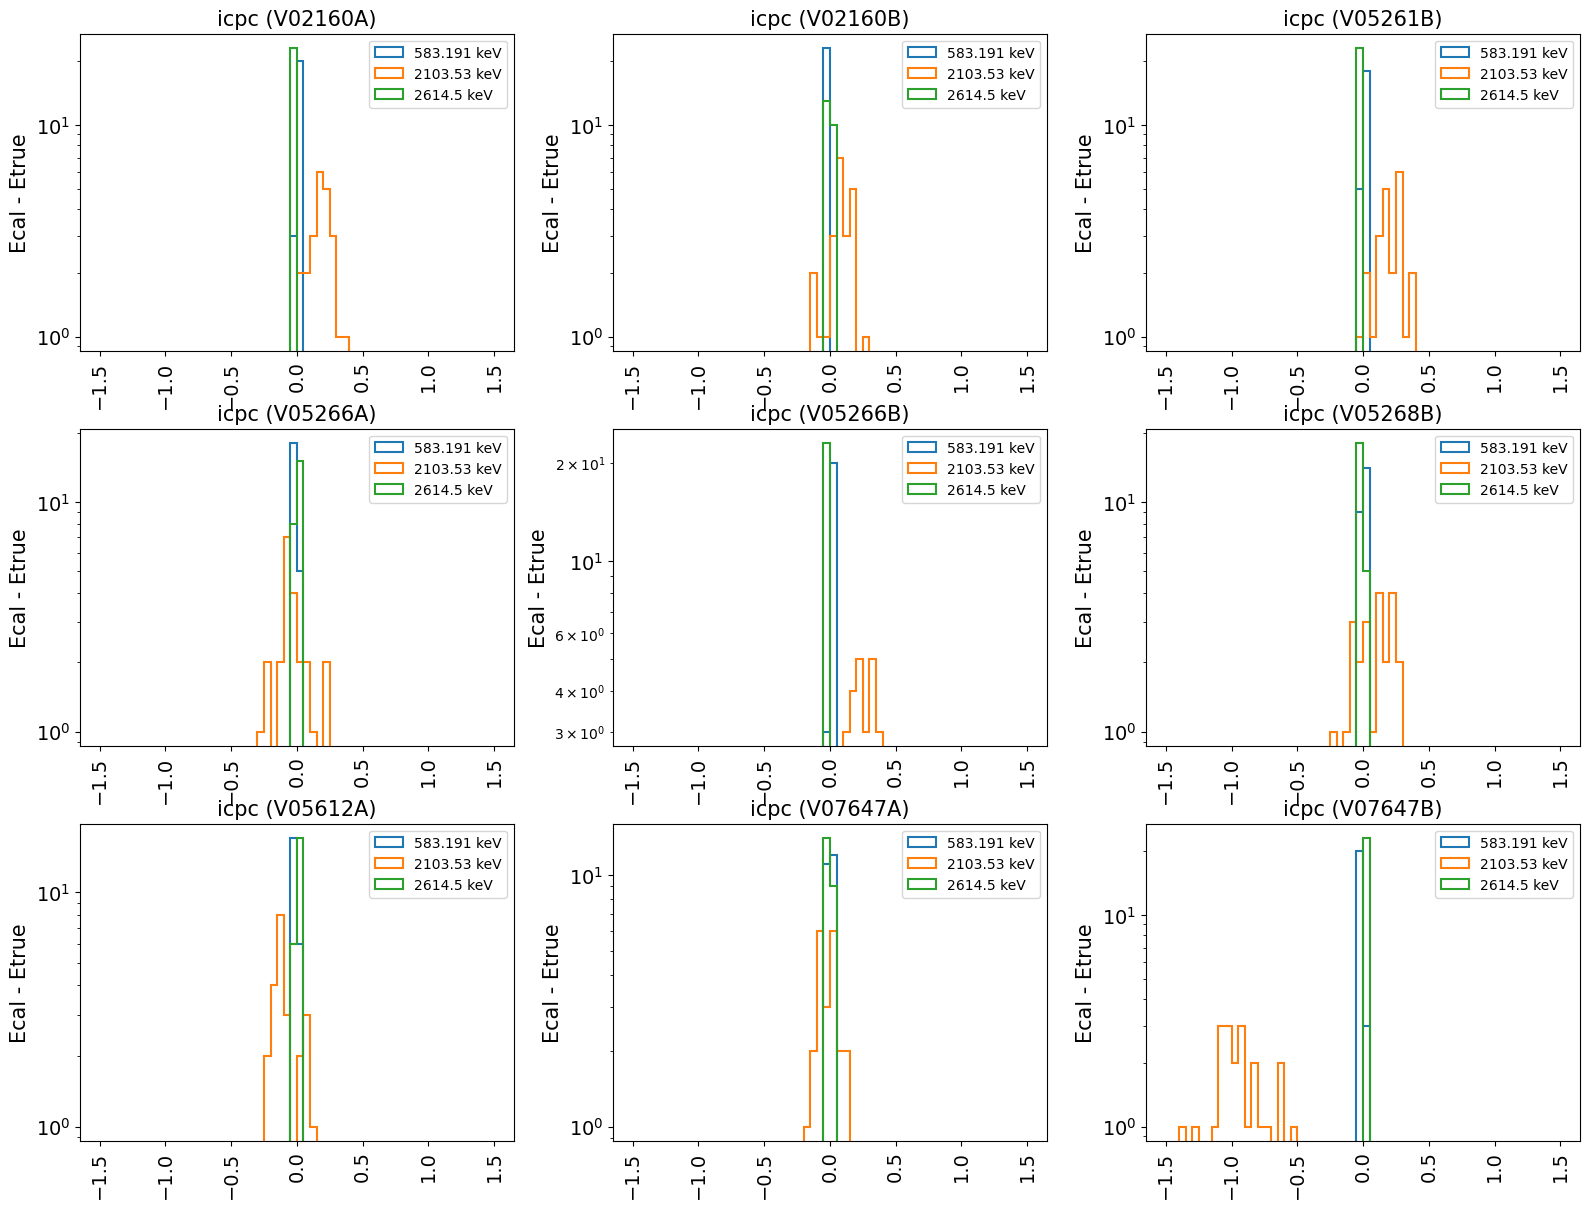

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
    det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
    for peak in [all_fitted_peaks[0], all_fitted_peaks[5], all_fitted_peaks[6]]:
        ax.hist(np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, bins=60, range=(-1.5, 1.5), histtype='step', linewidth=1.5, label=f'{peak} keV')
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(det_type, fontsize=15)
    ax.set_ylabel('Ecal - Etrue', fontsize=15)
    #ax.set_xlim(-0.5, 0.5)
    ax.set_yscale('log')
    ax.legend()
plt.tight_layout()
plt.show()

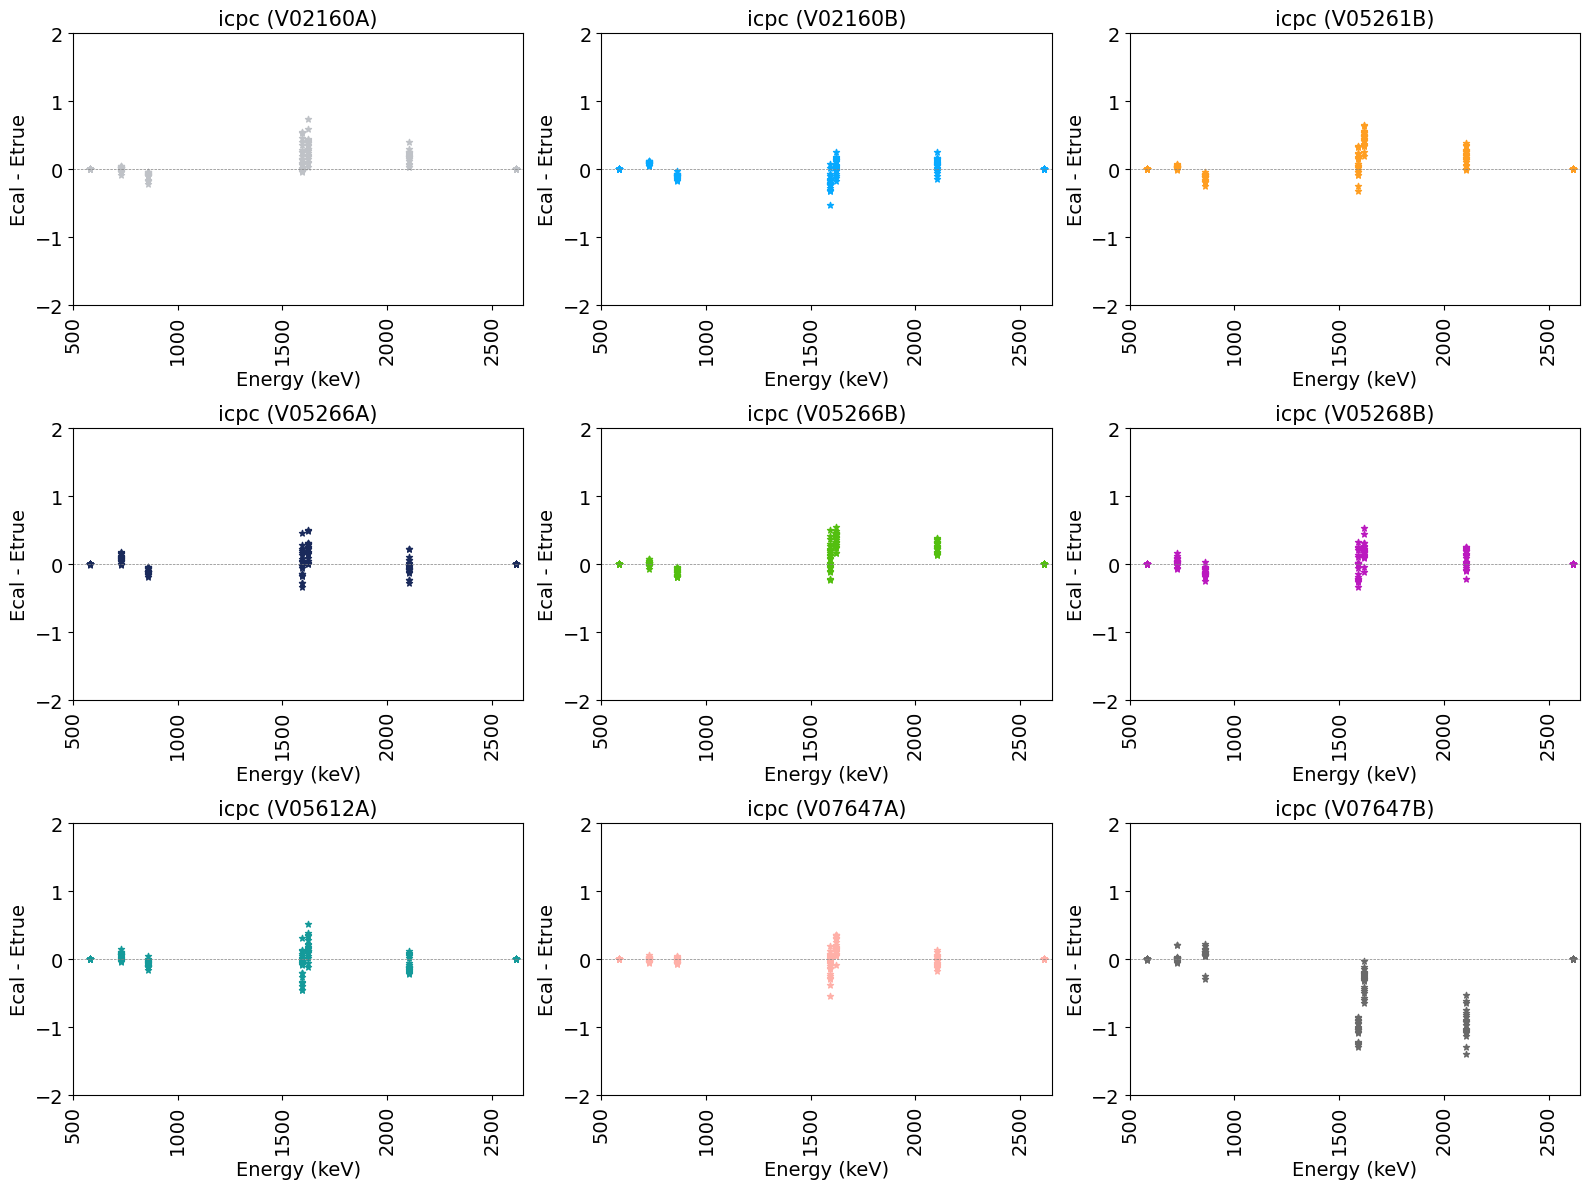

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
    det_type = channel_dict[int(channel[2:])][0] + f' ({channel_dict[int(channel[2:])][1]})'
    ax.axhline(y=0, linestyle='--', linewidth=0.5, color='grey')
    for i, peak in enumerate(all_fitted_peaks):
        ax.scatter(np.full(len(all_params_ch[channel]['ecals_peaks'][peak].values()), peak), np.array(list(all_params_ch[channel]['ecals_peaks'][peak].values())) - peak, marker='*', s=20, color=col)
    ax.tick_params(axis='x', labelsize=14, rotation=90)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Energy (keV)', fontsize=14)
    ax.set_ylabel('Ecal - Etrue', fontsize=14)
    ax.set_title(det_type, fontsize=15)
    ax.set_xlim(500, 2650)
    ax.set_ylim(-2, 2)
plt.tight_layout()
plt.show()

### Gain and mu position

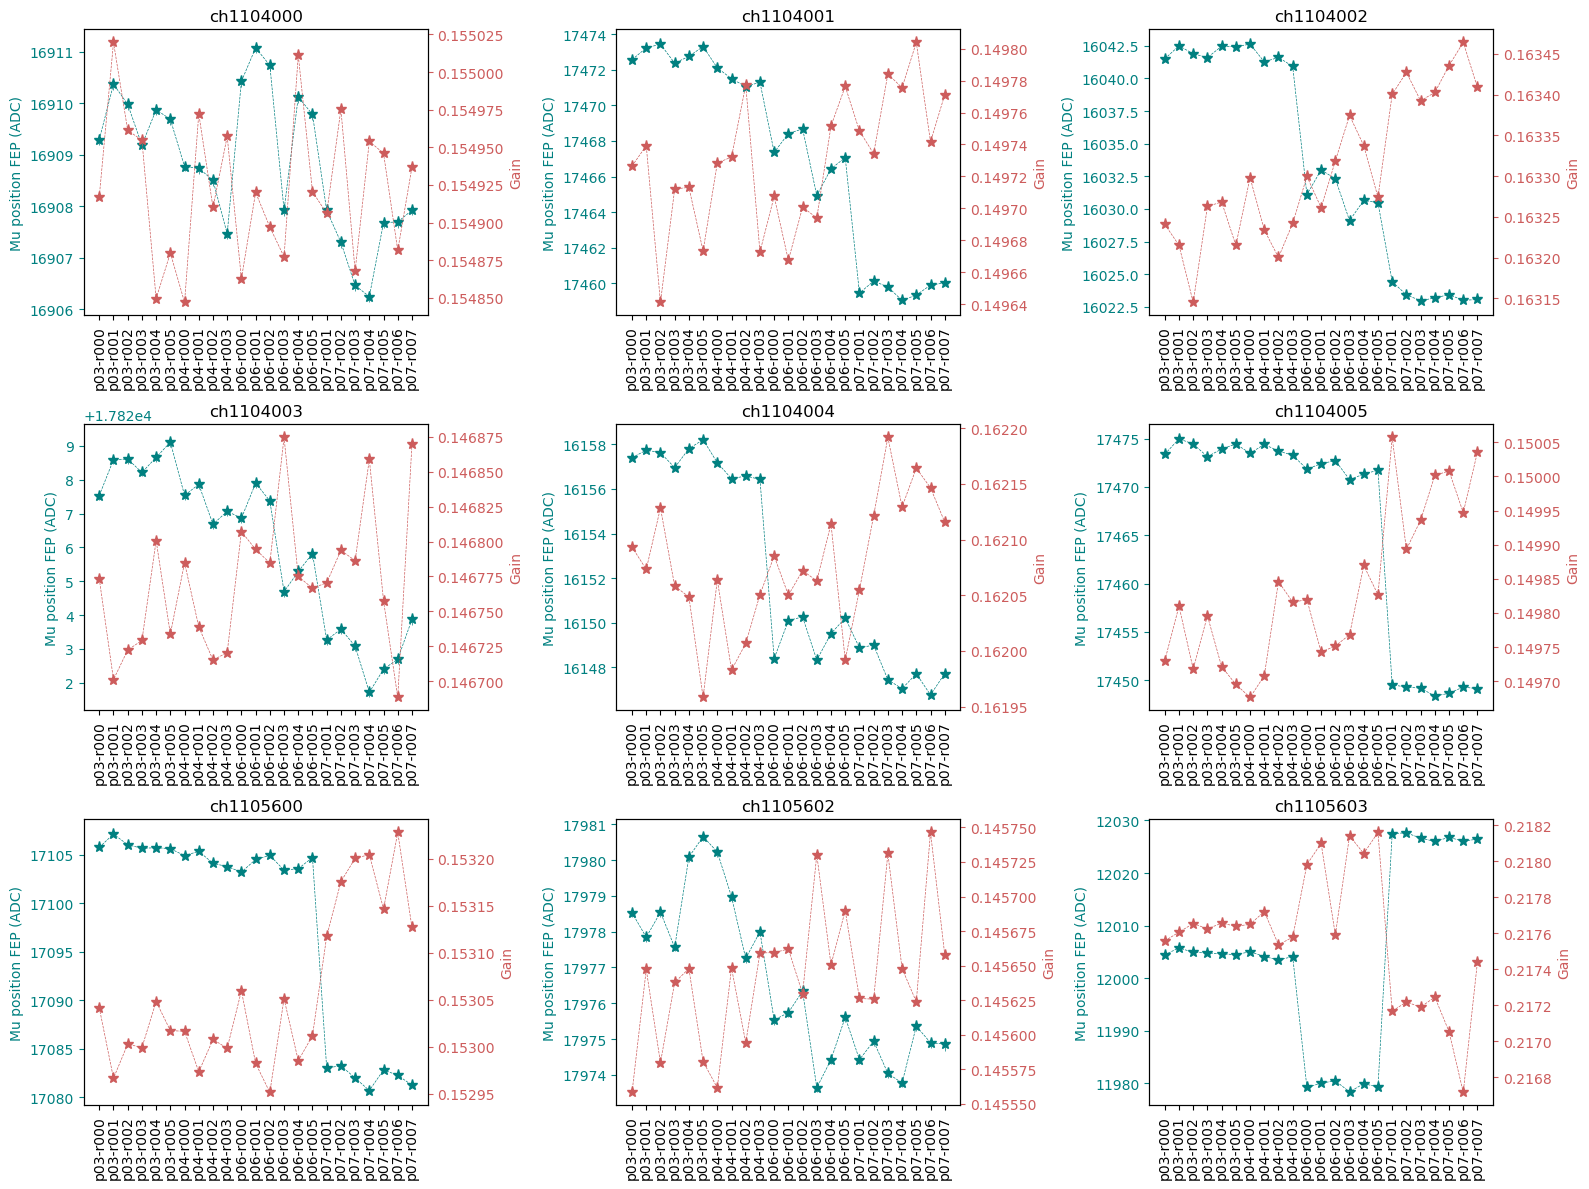

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ax, channel in zip(axs.flatten(), channels_string1):
    ax2 = ax.twinx()    
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][2614.5].keys()), 
                list(all_params_ch[channel]['mus_peaks'][2614.5].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][2614.5].values()), 
                marker='*', linestyle='--', markersize=8, label=channel, color='teal', linewidth=0.5)
    
    ax2.errorbar([list(i.keys  ())[0] for i in all_params_ch[channel]['gains']],
                [list(i.values())[0] for i in all_params_ch[channel]['gains']],
                 marker='*', linestyle='--', markersize=8, label=f'Channel {channel}', color='indianred', linewidth=0.5)
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.tick_params( axis='y', labelsize=10, colors='teal')
    ax2.set_ylabel('Gain', color='indianred')
    ax2.tick_params(axis='y', labelsize=10, colors='indianred')
    
    
    ax.set_ylabel('Mu position FEP (ADC)', color='teal')
    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.set_title(channel)
    #ax.set_ylim(0.146, 0.16)
plt.tight_layout()
plt.show()

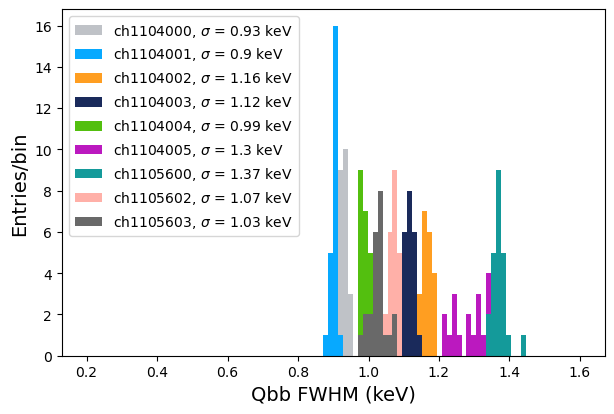

In [21]:
plt.figure(figsize=(7, 4.5))
for i, (channel, col) in enumerate(zip(channels_string1, string_colors)):
    Qbb_fwhm_ch   = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    Qbb_fwhm_keys = np.array([list(el.keys  ())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_keV']])
    plt.hist(Qbb_fwhm_ch/2.355, bins=100, range=(0.2, 1.6), color=col, label=channel+f', $\sigma$ = {np.round(np.mean(Qbb_fwhm_ch/2.355), decimals=2)} keV')
plt.xlabel('Qbb FWHM (keV)', fontsize=14)
plt.ylabel('Entries/bin',    fontsize=14)
plt.legend(fontsize=10)
plt.show()

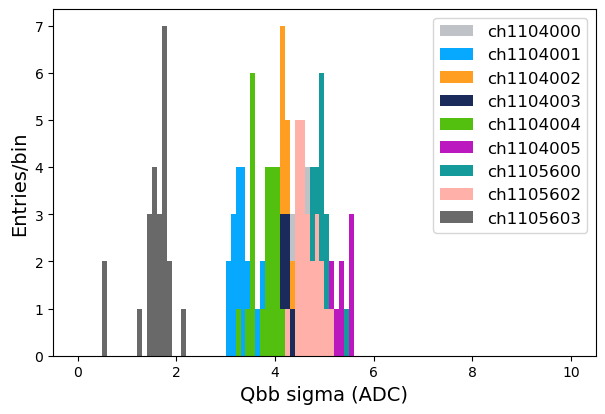

In [22]:
plt.figure(figsize=(7, 4.5))
for i, (channel, col) in enumerate(zip(channels_string1, string_colors)):
    Qbb_fwhm_uncal = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])
    Qbb_sig_uncal  = Qbb_fwhm_uncal/2.355
    plt.hist(Qbb_sig_uncal, bins=100, range=(0, 10), color=col, label=channel)
plt.xlabel('Qbb sigma (ADC)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Partitions

In [23]:
def compute_and_plot_partition(channel, peak, col):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=10, label=det_type, color=col)
    for i,col in zip(range(len(partition_change)-1), ['teal', 'grey', 'orange', 'indianred', 'teal']):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(f'{det_type}, ({det_name})', fontsize=13)
    ax.set_ylabel('Mu position (ADC)', fontsize=13)
    ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-30,
                np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+30)
        
    plt.show()

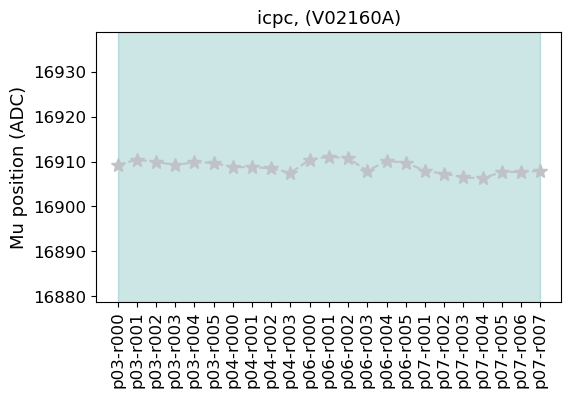

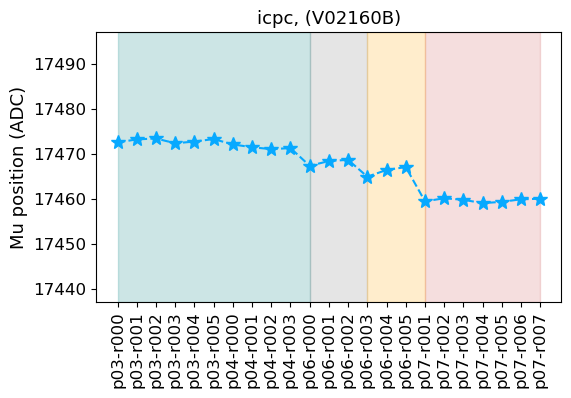

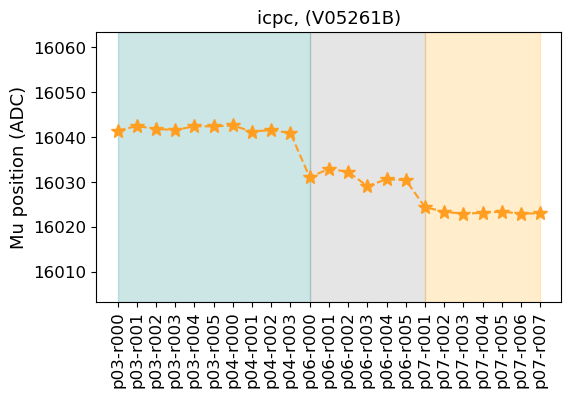

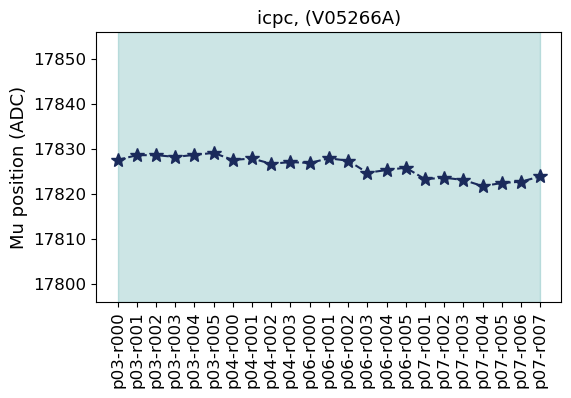

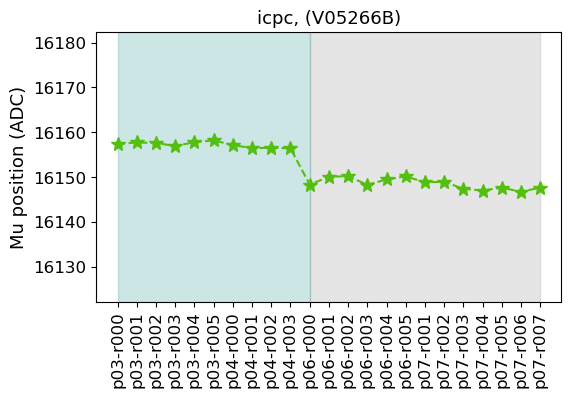

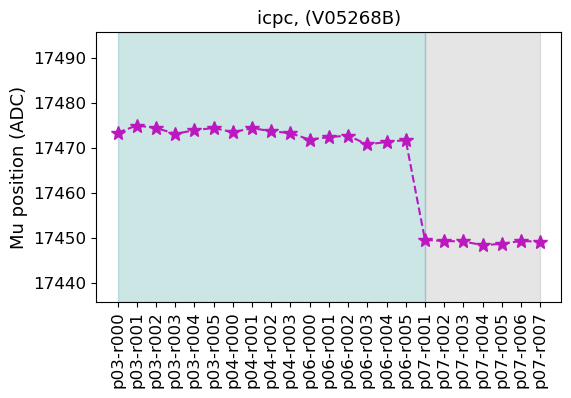

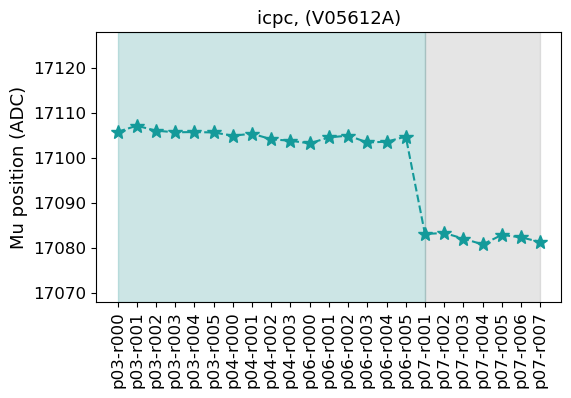

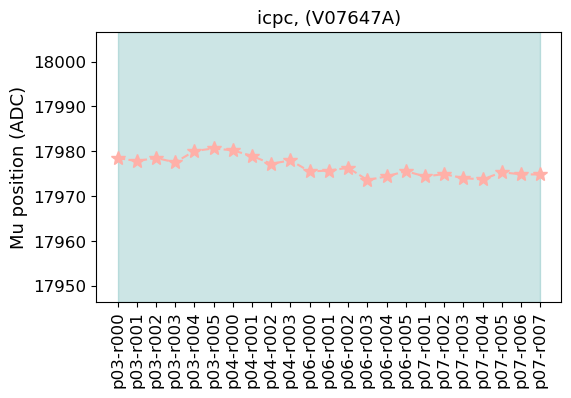

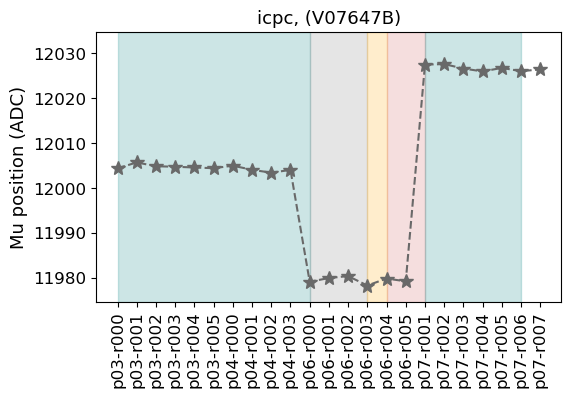

In [24]:
for channel, col in zip(channels_string1, string_colors):
    compute_and_plot_partition(channel, all_fitted_peaks[6], col)

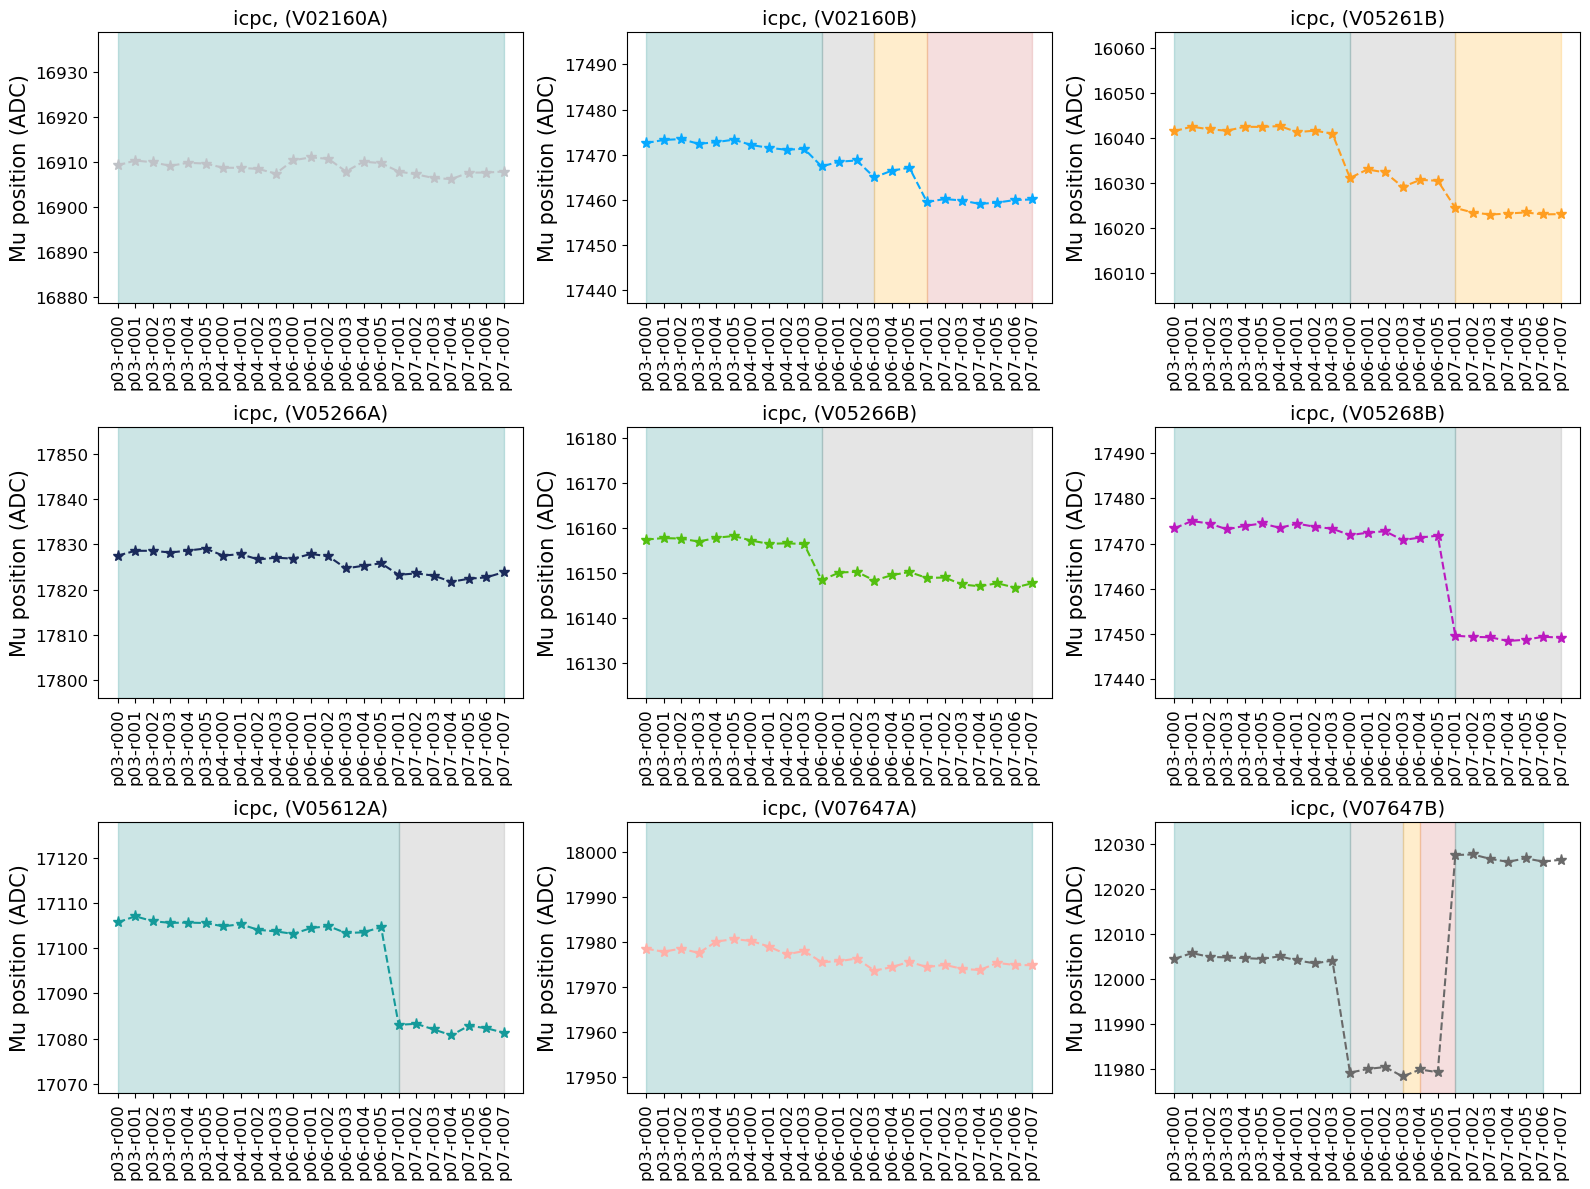

In [25]:
peak = all_fitted_peaks[6]
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for i, (ax, channel, col) in enumerate(zip(axs.flatten(), channels_string1, string_colors)):
    mus    = list(all_params_ch[channel]['mus_peaks'][peak].values())
    sigmas = np.array([list(el.values())[0] for el in all_params_ch[channel]['Qbb_fwhms_in_ADC']])/2.355
    
    partition_change = [0]
    start_mu = 0
    for i,(mu,sig) in enumerate(zip(mus, sigmas)):
        if i==0:
            start_mu = mu
        else:
            if np.abs(mu - start_mu) > np.abs(sig):
                partition_change.append(i)
            start_mu = mu
    partition_change.append(len(mus)-1)
    
    det_type = channel_dict[int(channel[2:])][0]
    det_name = channel_dict[int(channel[2:])][1]
    ax.errorbar(list(all_params_ch[channel]['mus_peaks'][peak].keys()), 
                list(all_params_ch[channel]['mus_peaks'][peak].values()),
                yerr=list(all_params_ch[channel]['mus_err_peaks'][peak].values()), 
                marker='*', linestyle='--', markersize=8, label=det_type, color=col)
    for i,col in zip(range(len(partition_change)-1), ['teal', 'grey', 'orange', 'indianred', 'teal']):
        ax.axvspan(list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i]], 
                   list(all_params_ch[channel]['mus_peaks'][peak].keys())[partition_change[i+1]], alpha=0.2, color=col)
    ax.tick_params(axis='x', labelsize=12, rotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(f'{det_type}, ({det_name})', fontsize=14)
    ax.set_ylabel('Mu position (ADC)', fontsize=15)
    ax.set_ylim(np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))-30,
                np.mean(list(all_params_ch[channel]['mus_peaks'][peak].values()))+30)
    
plt.tight_layout()    
plt.show()